In [1]:
#%load_ext autoreload
#%autoreload 2


import sys
sys.path.append("../../mrf-sim/")
sys.path.append("../../epgpy/")
sys.path.append("../../machines/")
sys.path.append("../../mutools/")
sys.path.append("../../dicomstack/")


#import matplotlib
#matplotlib.u<se("TkAgg")
from mrfsim import T1MRF
from image_series import *
from dictoptimizers import SimpleDictSearch,BruteDictSearch
from utils_mrf import *

import json
import readTwix as rT
import time
import os
from numpy.lib.format import open_memmap
from numpy import memmap
import pickle
from scipy.io import loadmat,savemat
import twixtools
from mutools import io
import cv2
import scipy
%matplotlib inline

import numpy as np


Could not import SPIJN


# Noisy dico signals

In [2]:
dictfile='../mrf144w8_SeqFF_PWCR_SimRecoFFDf_light.dict'
#dictfile='../mrf175_SimReco2_light.dict'
mrfdict = dictsearch.Dictionary()
mrfdict.load(dictfile, force=True)
total_nb_signals=mrfdict.values.shape[0]

In [3]:
mask=None
snr=10
ff=0.5
nb_signals=60

In [4]:
#nb_signals=np.minimum(nb_signals,total_nb_signals)

phase_0=np.pi*np.random.uniform()
print(phase_0)
ind=np.random.choice(total_nb_signals,size=nb_signals)
keys=np.array(mrfdict.keys)[ind]
all_signals=((1-ff)*mrfdict.values[ind,:,0].T+ff*mrfdict.values[ind,:,1].T)*np.exp(-1j*phase_0)

noise=(np.random.normal(size=(all_signals.shape))+1j*np.random.normal(size=(all_signals.shape)))
noise*=np.abs(np.expand_dims(np.mean(all_signals,axis=1),axis=1))/snr/np.abs(noise)
all_signals=all_signals+noise
all_signals/=np.linalg.norm(all_signals,axis=0)

2.2127166336095474


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


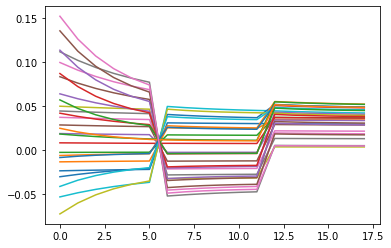

In [5]:
plt.plot(mrfdict.values[:,:,1].T)

In [7]:
pca = True
threshold_pca_bc = 20
threshold_pca_brute=20

In [8]:
nb_signals=all_signals.shape[1]
split=nb_signals+1

In [9]:
dict_optim_brute=BruteDictSearch(FF_list=np.arange(0,1.01,0.01),mask=mask,split=split,pca=pca,threshold_pca=threshold_pca_brute,log=False,useGPU_dictsearch=False,ntimesteps=None,log_phase=False,return_matched_signals=True)
dict_optim_bc_cf =SimpleDictSearch(mask=mask, niter=0, seq=None, trajectory=None, split=split, pca=pca,
                                threshold_pca=threshold_pca_bc, log=False, useGPU_dictsearch=False, useGPU_simulation=False,
                                gen_mode="other", movement_correction=False, cond=None, ntimesteps=None,return_matched_signals=True)
dict_optim_bc_matrix = dict_optim_bc_cf

In [10]:


all_maps_brute,matched_signals_brute=dict_optim_brute.search_patterns(dictfile,all_signals)
all_maps_bc_cf,matched_signals_bc_cf=dict_optim_bc_cf.search_patterns_test(dictfile,all_signals)
all_maps_bc_matrix,matched_signals_bc_matrix=dict_optim_bc_matrix.search_patterns_matrix(dictfile,all_signals)

Calculating optimal fat fraction and best pattern per signal
There are 60 unique signals to match along 2727 dic components


100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


Building the maps for iteration
Water Components Retained 20 out of 18 timesteps
Fat Components Retained 20 out of 18 timesteps
################# ITERATION : Number 0 out of 0 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 0
There are 60 unique signals to match along 27 water and 27 fat components


100%|██████████| 1/1 [00:00<00:00, 510.75it/s]


(60,)
(60,)
(18, 60)
Maps build for iteration 0
There are 60 unique signals to match along 27 components


100%|██████████| 1/1 [00:00<00:00, 353.74it/s]


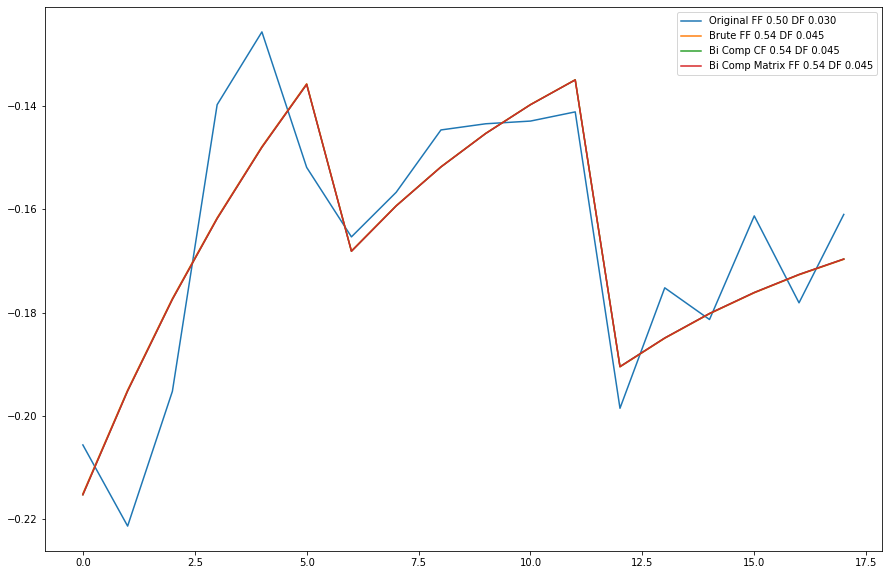

In [11]:
j=np.random.choice(nb_signals)
metric=np.real
plt.figure(figsize=(15,10))
plt.plot(metric(all_signals[:,j]),label="Original FF {0:.2f} DF {1:.3f}".format(ff,keys[j,-1]))
plt.plot(metric(matched_signals_brute[:,j]),label="Brute FF {0:.2f} DF {1:.3f}".format(all_maps_brute[0][0]["ff"][j],all_maps_brute[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_cf[:,j]),label="Bi Comp CF {0:.2f} DF {1:.3f}".format(all_maps_bc_cf[0][0]["ff"][j],all_maps_bc_cf[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_matrix[:,j]),label="Bi Comp Matrix FF {0:.2f} DF {1:.3f}".format(all_maps_bc_matrix[0][0]["ff"][j],all_maps_bc_matrix[0][0]["df"][j]))
plt.legend()

In [12]:
correls_bc_matrix=[]
correls_bc_cf=[]
correls_brute=[]

correls_brute=[]
for i in range(nb_signals):
    correls_bc_matrix.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_matrix[:,i]))[0,1])
    correls_brute.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_brute[:,i]))[0,1])
    correls_bc_cf.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_cf[:,i]))[0,1])
    
correls_bc_matrix=np.array(correls_bc_matrix)
correls_bc_cf=np.array(correls_bc_cf)
correls_brute=np.array(correls_brute)


In [13]:
df_correls = pd.DataFrame(columns=["Brute","BC Matrix","BC CF"],data=np.stack([correls_brute,correls_bc_matrix,correls_bc_cf],axis=-1))

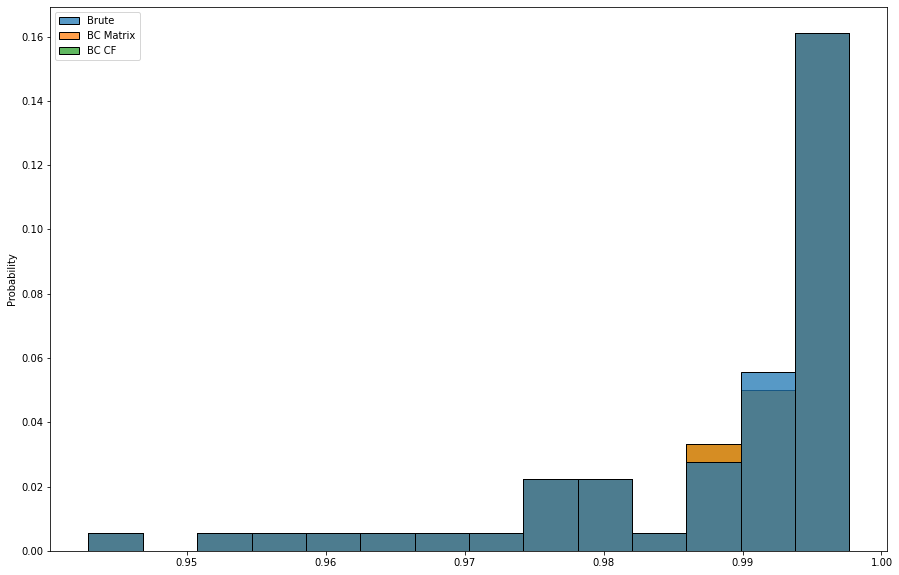

In [14]:
import seaborn as sns
plt.figure(figsize=(15,10))
#df_correls, hist = False, kde = True,
#                 kde_kws = {'shade': True, 'linewidth': 3})

sns.histplot(df_correls,stat="probability");

In [15]:
data_ff=pd.DataFrame(data=np.stack([[ff]*nb_signals,all_maps_brute[0][0]["ff"],all_maps_bc_cf[0][0]["ff"],all_maps_bc_matrix[0][0]["ff"]],axis=-1),columns=["FF Truth","FF Brute","FF CF","FF Matrix"])
data_df=pd.DataFrame(data=np.stack([keys[:,-1],all_maps_brute[0][0]["df"],all_maps_bc_cf[0][0]["df"],all_maps_bc_matrix[0][0]["df"]],axis=-1),columns=["DF Truth","DF Brute","DF CF","DF Matrix"])

data=pd.concat([data_df,data_ff],axis=1)

cols_df=[col for col in data.columns if "DF" in col]
df_min=data.describe()[cols_df].loc["min",:].min()
df_max=data.describe()[cols_df].loc["max",:].max()

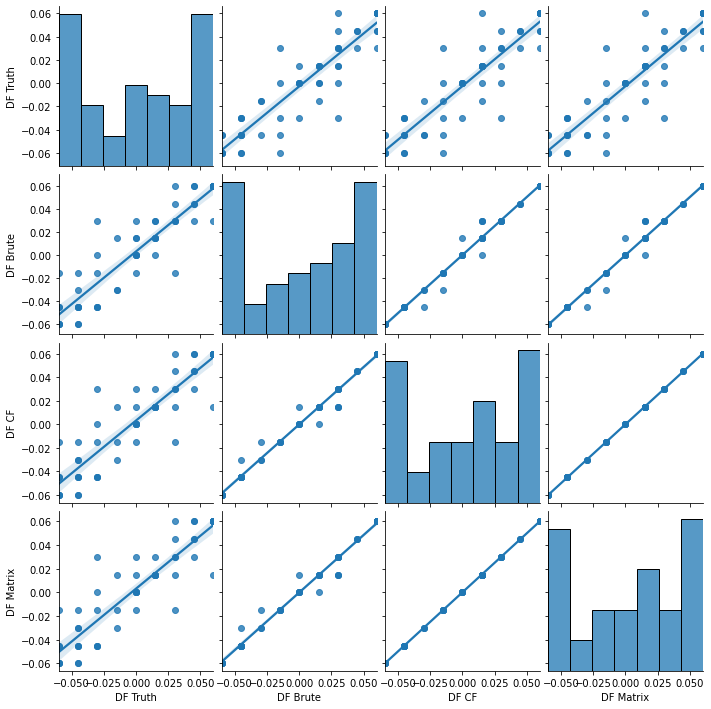

In [17]:
sns.pairplot(data_df,kind='reg')

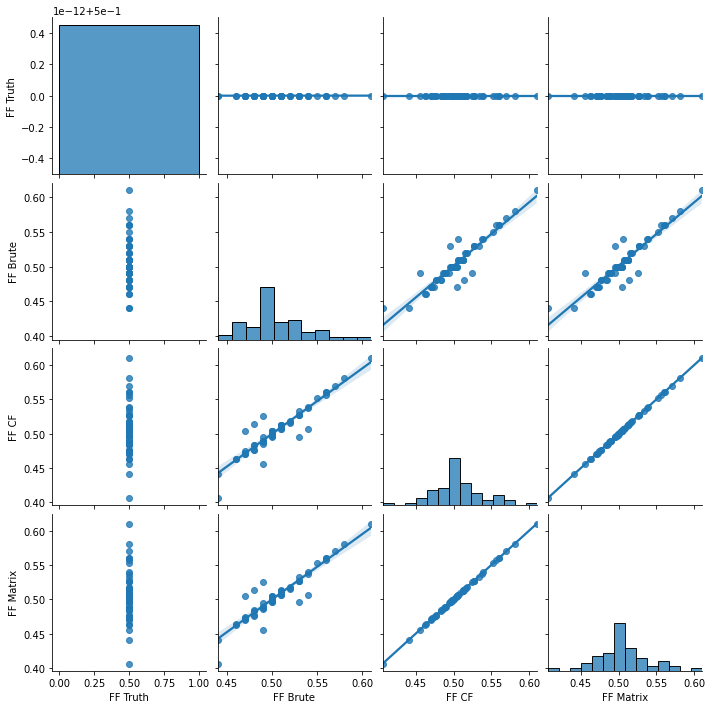

In [18]:
sns.pairplot(data_ff,kind='reg')

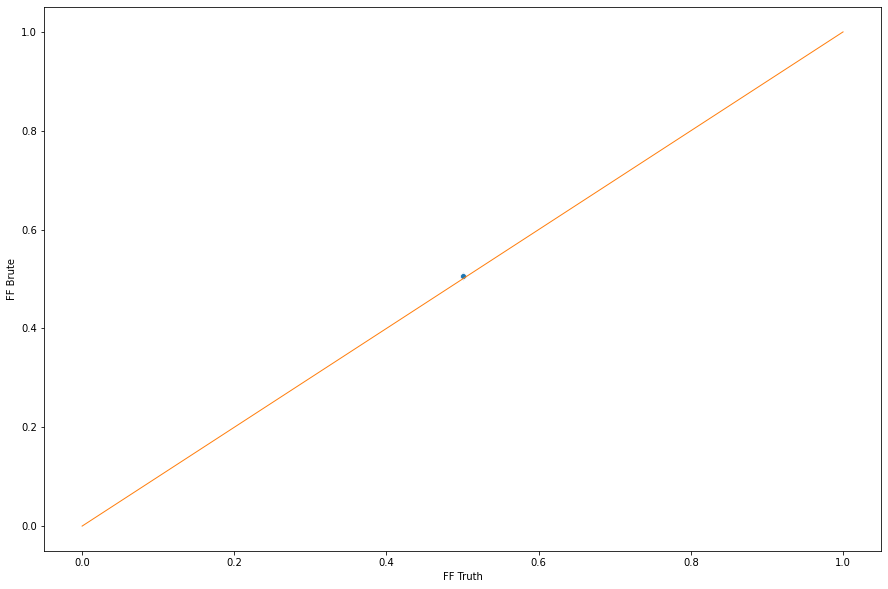

In [19]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Truth",y="FF Brute",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

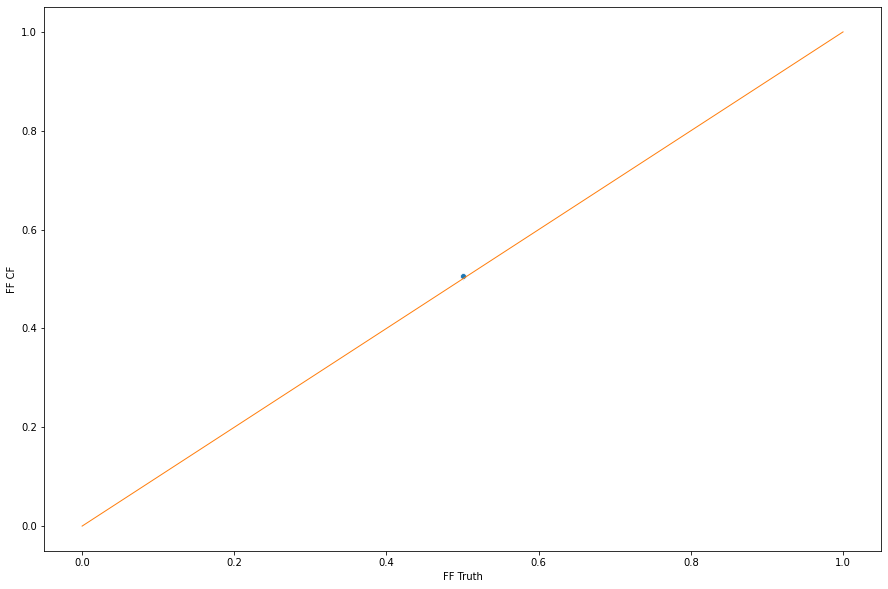

In [20]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Truth",y="FF CF",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

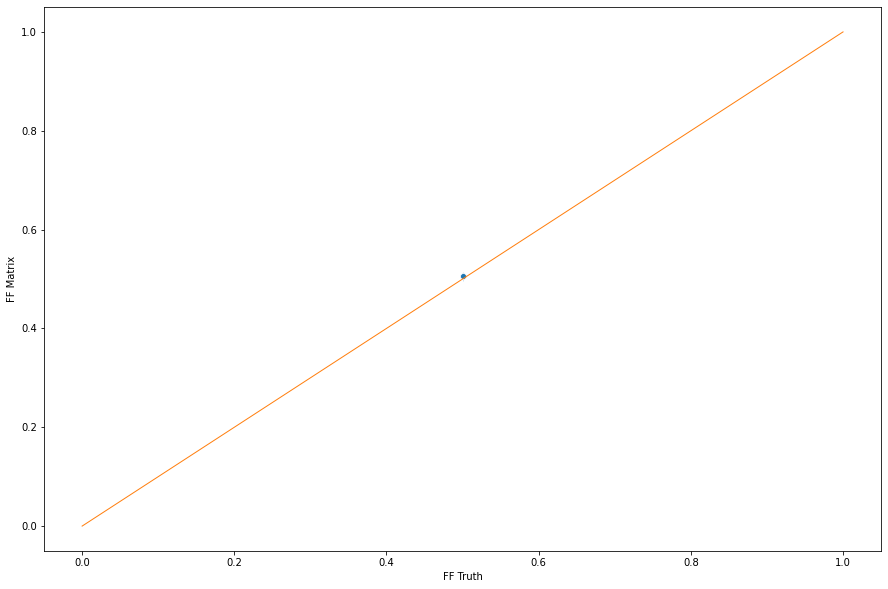

In [21]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Truth",y="FF Matrix",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

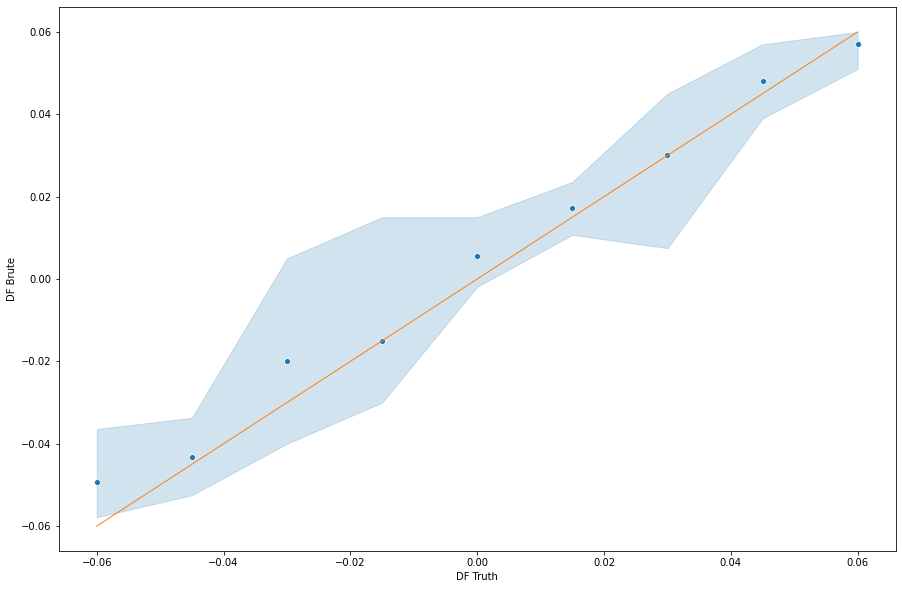

In [22]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Truth",y="DF Brute",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

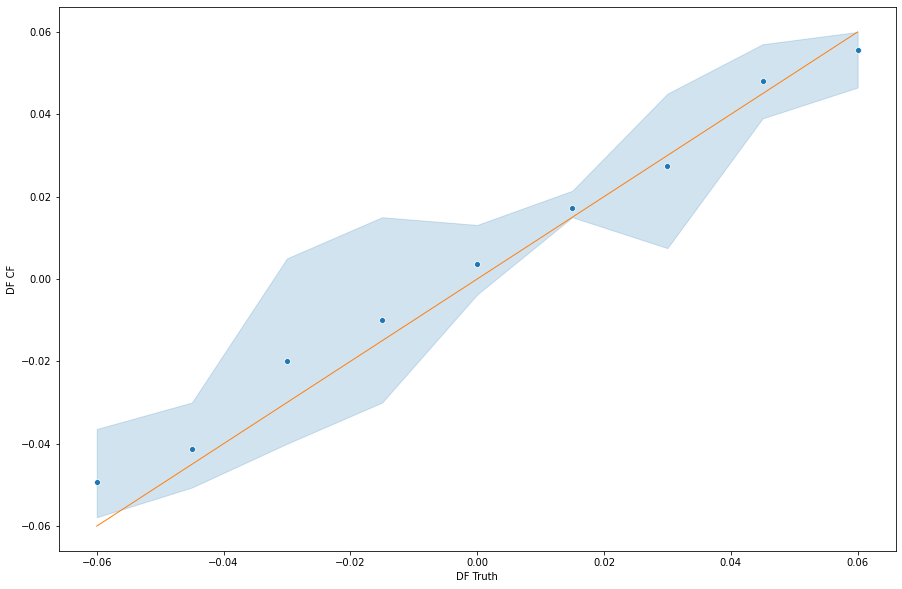

In [23]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Truth",y="DF CF",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

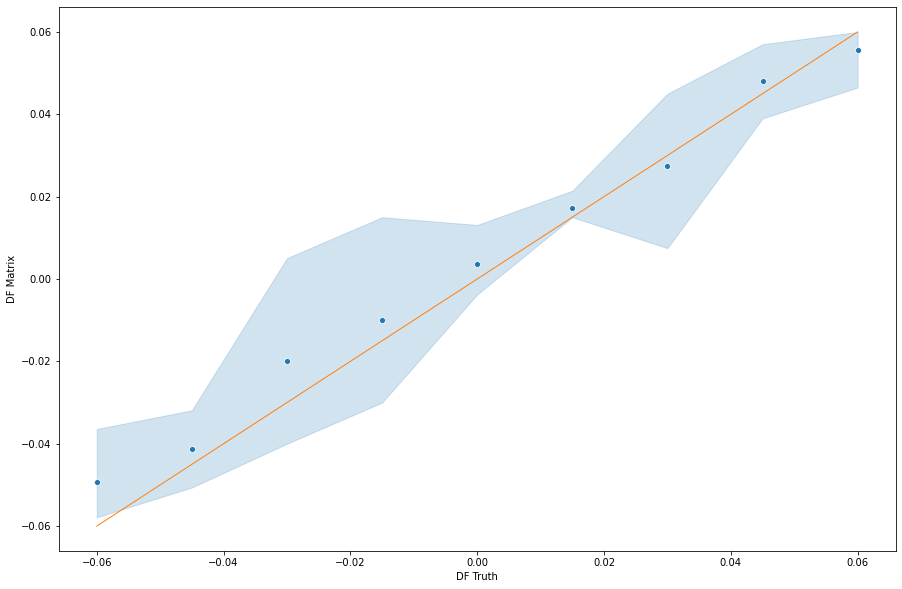

In [24]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Truth",y="DF Matrix",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

# Simulation

## FF MRF

In [25]:

base_folder = "../3D"

suffix=""
suffix="_FFDf"
#suffix="_Cohen"
#suffix="_CohenWeighted"
#suffix="_CohenCSWeighted"
#suffix="_CohenBS"
#suffix="_PW"
suffix="_PWCR"
#suffix="_PWWeighted"
#suffix="_"

nb_allspokes = 144
nspoke=8
nb_segments=nb_allspokes
ntimesteps=int(nb_segments/nspoke)





nb_filled_slices = 8
nb_empty_slices=2
repeat_slice=1
nb_slices = nb_filled_slices+2*nb_empty_slices

undersampling_factor=1

is_random=False
frac_center=1.0

name = "SquareSimu3D"


localfile="/"+name
filename = base_folder+localfile

folder = "/".join(str.split(filename,"/")[:-1])

filename_volume = filename+"_volumes_sl{}_rp{}_us{}_{}w{}{}.npy".format(nb_slices,repeat_slice,undersampling_factor,nb_allspokes,nspoke,suffix)
filename_mask= filename+"_mask_sl{}_rp{}_us{}{}w{}{}.npy".format(nb_slices,repeat_slice,undersampling_factor,nb_allspokes,nspoke,suffix)
filename_paramMap=filename+"_paramMap_sl{}_rp{}{}.pkl".format(nb_slices,repeat_slice,"")



dictfile='../mrf144w8_SeqFF_PWCR_SimRecoFFDf_light.dict'

In [26]:
mask=np.load(filename_mask)
volumes_all=np.load(filename_volume)
with open(filename_paramMap, "rb") as file:
    paramMap=pickle.load(file)


FileNotFoundError: [Errno 2] No such file or directory: '../3D/SquareSimu3D_mask_sl12_rp1_us1144w8_PWCR.npy'

In [4]:
all_signals=volumes_all[:,mask>0]
all_signals/=np.linalg.norm(all_signals,axis=0)

In [5]:
nb_signals=10000

In [6]:
total_nb_signals=all_signals.shape[1]

nb_signals=np.minimum(total_nb_signals,nb_signals)
ind=np.random.choice(total_nb_signals,size=nb_signals,replace=False)
ff_gt=paramMap["ff"][ind]
df_gt=paramMap["df"][ind]

all_signals=all_signals[:,ind]


In [7]:
pca = True
threshold_pca_bc = 20
threshold_pca_brute=20

In [8]:
nb_signals=all_signals.shape[1]
split=nb_signals+1
dict_optim_brute=BruteDictSearch(FF_list=np.arange(0,1.01,0.01),mask=mask,split=split,pca=pca,threshold_pca=threshold_pca_brute,log=False,useGPU_dictsearch=False,ntimesteps=None,log_phase=False,return_matched_signals=True)
dict_optim_bc =SimpleDictSearch(mask=mask, niter=0, seq=None, trajectory=None, split=split, pca=pca,
                                threshold_pca=threshold_pca_bc, log=False, useGPU_dictsearch=False, useGPU_simulation=False,
                                gen_mode="other", movement_correction=False, cond=None, ntimesteps=None,return_matched_signals=True)
#dict_optim_bc_matrix = dict_optim_bc_cf



all_maps_brute,matched_signals_brute=dict_optim_brute.search_patterns(dictfile,all_signals)
all_maps_bc_cf,matched_signals_bc_cf=dict_optim_bc.search_patterns_test(dictfile,all_signals)
all_maps_bc_matrix,matched_signals_bc_matrix=dict_optim_bc.search_patterns_matrix(dictfile,all_signals)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Calculating optimal fat fraction and best pattern per signal
There are 8192 unique signals to match along 2727 dic components


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]


Building the maps for iteration


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Water Components Retained 20 out of 18 timesteps
Fat Components Retained 20 out of 18 timesteps
################# ITERATION : Number 0 out of 0 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 0
There are 8192 unique signals to match along 27 water and 27 fat components
(8192,)
(8192,)
(18, 8192)
Maps build for iteration 0
There are 8192 unique signals to match along 27 components


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


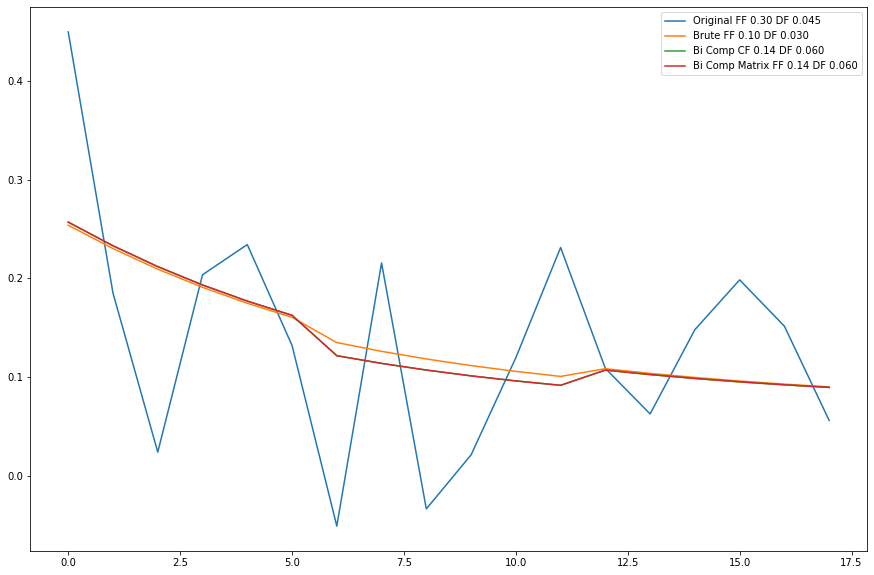

In [10]:
j=np.random.choice(nb_signals)
metric=np.real
plt.figure(figsize=(15,10))
plt.plot(metric(all_signals[:,j]),label="Original FF {0:.2f} DF {1:.3f}".format(ff_gt[j],df_gt[j]))
plt.plot(metric(matched_signals_brute[:,j]),label="Brute FF {0:.2f} DF {1:.3f}".format(all_maps_brute[0][0]["ff"][j],all_maps_brute[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_cf[:,j]),label="Bi Comp CF {0:.2f} DF {1:.3f}".format(all_maps_bc_cf[0][0]["ff"][j],all_maps_bc_cf[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_matrix[:,j]),label="Bi Comp Matrix FF {0:.2f} DF {1:.3f}".format(all_maps_bc_matrix[0][0]["ff"][j],all_maps_bc_matrix[0][0]["df"][j]))
plt.legend()

In [11]:
correls_bc_matrix=[]
correls_bc_cf=[]
correls_brute=[]

correls_brute=[]
for i in range(nb_signals):
    correls_bc_matrix.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_matrix[:,i]))[0,1])
    correls_brute.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_brute[:,i]))[0,1])
    correls_bc_cf.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_cf[:,i]))[0,1])
    
correls_bc_matrix=np.array(correls_bc_matrix)
correls_bc_cf=np.array(correls_bc_cf)
correls_brute=np.array(correls_brute)
df_correls = pd.DataFrame(columns=["Brute","BC Matrix","BC CF"],data=np.stack([correls_brute,correls_bc_matrix,correls_bc_cf],axis=-1))

<Figure size 1080x720 with 0 Axes>

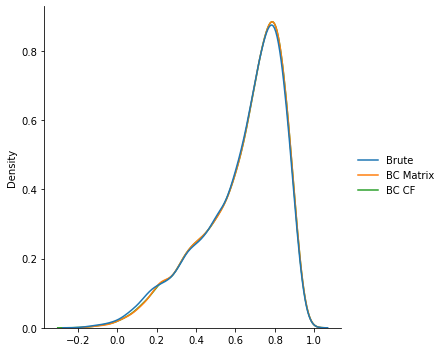

In [12]:
import seaborn as sns
plt.figure(figsize=(15,10))

sns.displot(df_correls,kind="kde");

In [13]:
df_correls.describe()

,Brute,BC Matrix,BC CF
count,8192.000000,8192.000000,8192.000000
mean,0.636617,0.642378,0.641962
std,0.206993,0.202511,0.203082
min,-0.172837,-0.143332,-0.201201
25%,0.517819,0.524645,0.523967
50%,0.694219,0.697926,0.697599
75%,0.794247,0.796821,0.796821
max,0.965192,0.965125,0.965125


In [14]:
data_ff=pd.DataFrame(data=np.stack([all_maps_brute[0][0]["ff"],all_maps_bc_cf[0][0]["ff"],all_maps_bc_matrix[0][0]["ff"]],axis=-1),columns=["FF Brute","FF CF","FF Matrix"])
data_df=pd.DataFrame(data=np.stack([all_maps_brute[0][0]["df"],all_maps_bc_cf[0][0]["df"],all_maps_bc_matrix[0][0]["df"]],axis=-1),columns=["DF Brute","DF CF","DF Matrix"])

data=pd.concat([data_df,data_ff],axis=1)


In [15]:
cols_df=[col for col in data.columns if "DF" in col]
df_min=data.describe()[cols_df].loc["min",:].min()
df_max=data.describe()[cols_df].loc["max",:].max()

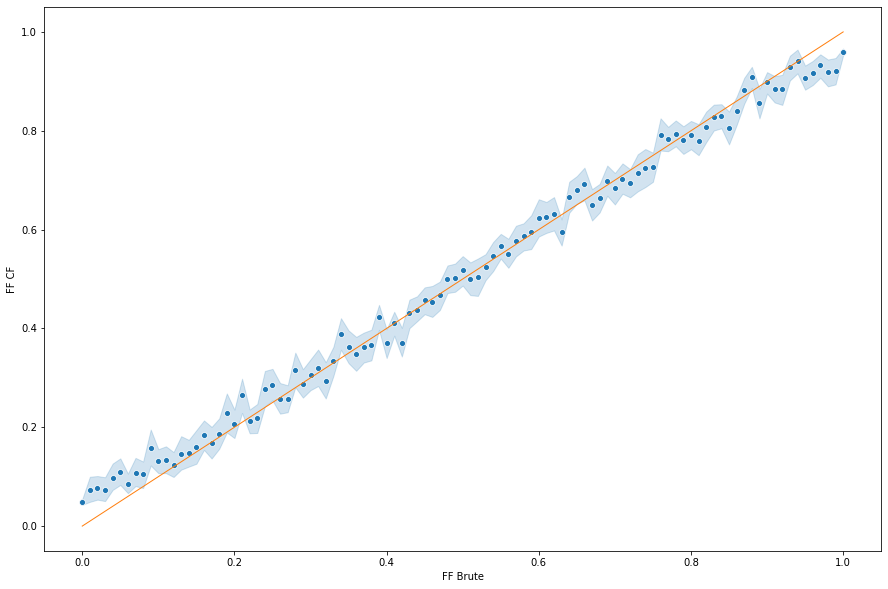

In [16]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Brute",y="FF CF",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

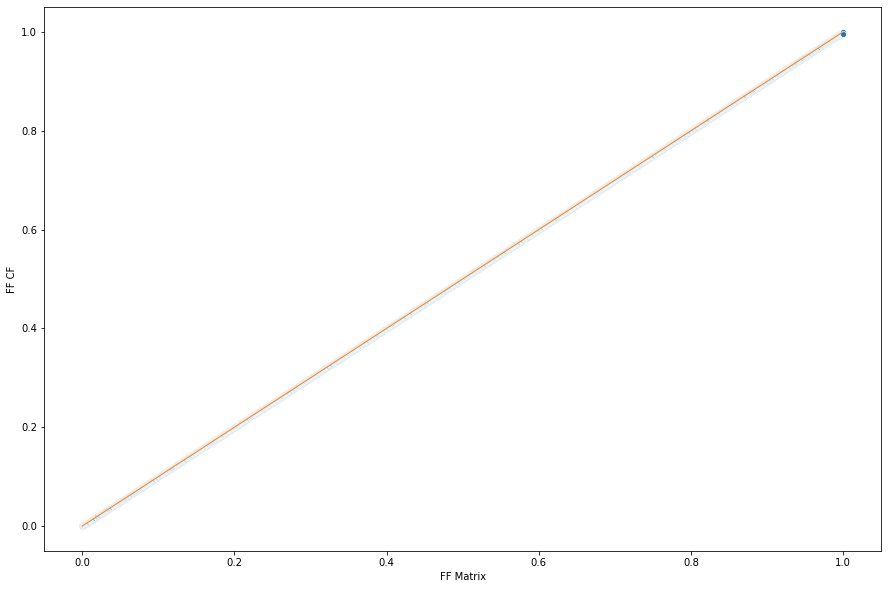

In [17]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Matrix",y="FF CF",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

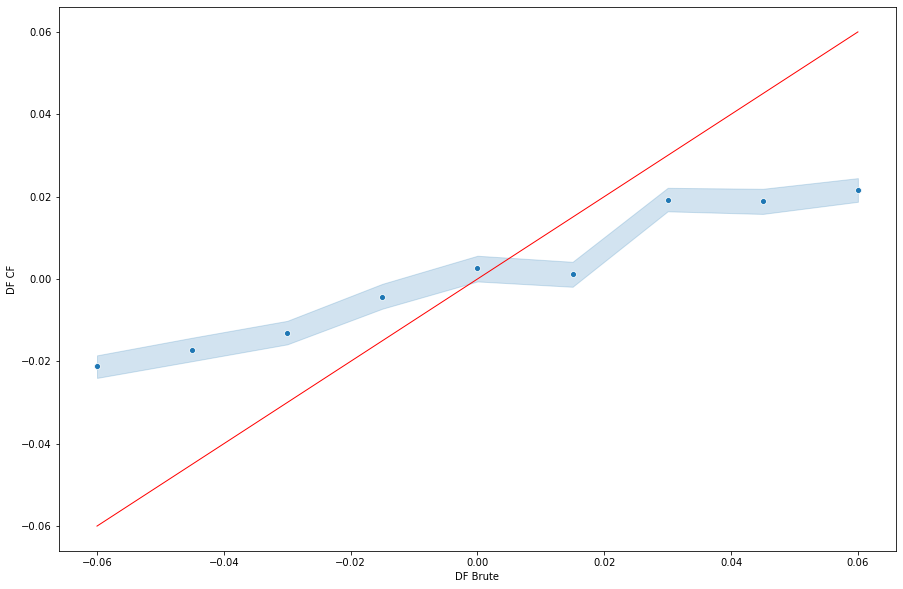

In [18]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Brute",y="DF CF",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1,c="r")

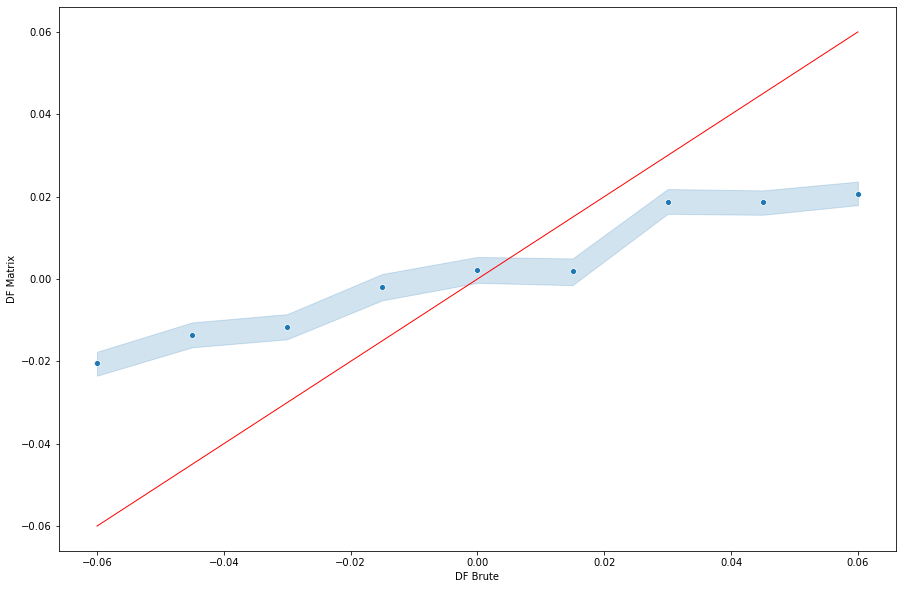

In [19]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Brute",y="DF Matrix",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1,c="r")


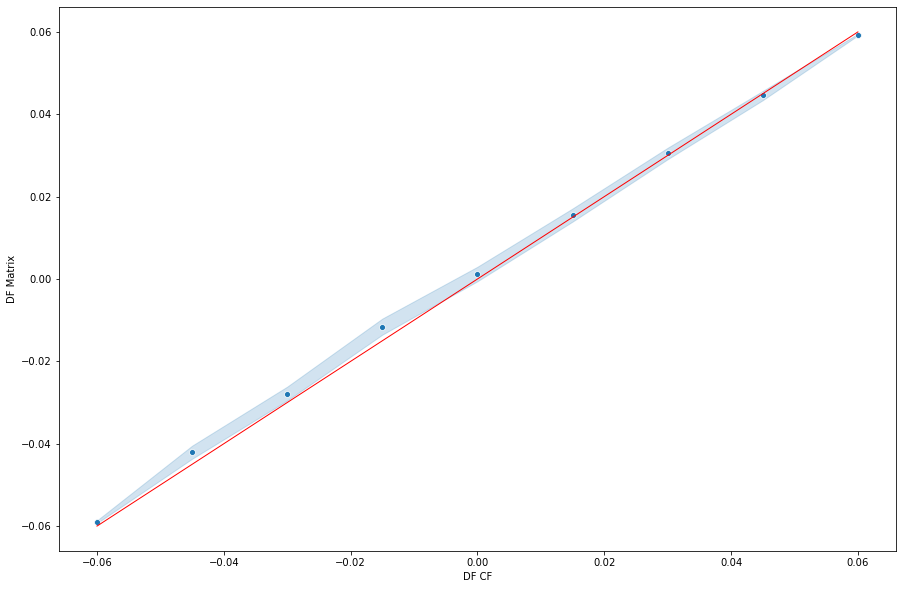

In [20]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF CF",y="DF Matrix",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1,c="r")


## MRF sequence

In [2]:

base_folder = "../3D"


suffix=""
nb_filled_slices = 8
nb_empty_slices=2
repeat_slice=1
nb_slices = nb_filled_slices+2*nb_empty_slices

nb_allspokes = 1400
nspoke=8


undersampling_factor=1


name = "SquareSimu3D"

localfile="/"+name
filename = base_folder+localfile

folder = "/".join(str.split(filename,"/")[:-1])


filename_paramMap=filename+"_paramMap_sl{}_rp{}{}.pkl".format(nb_slices,repeat_slice,"")
filename_mask= filename+"_mask_sl{}_rp{}_us{}{}w{}{}.npy".format(nb_slices,repeat_slice,undersampling_factor,nb_allspokes,nspoke,suffix)

filename_volume = filename+"_volumes_sl{}_rp{}_us{}_{}w{}{}.npy".format(nb_slices,repeat_slice,undersampling_factor,nb_allspokes,nspoke,suffix)
dictfile='../mrf175_SimReco2_light.dict'

In [3]:
mask=np.load(filename_mask)
volumes_all=np.load(filename_volume)
with open(filename_paramMap, "rb") as file:
    paramMap=pickle.load(file)


In [4]:
all_signals=volumes_all[:,mask>0]
all_signals/=np.linalg.norm(all_signals,axis=0)

In [5]:
nb_signals=1000

In [6]:
total_nb_signals=all_signals.shape[1]

nb_signals=np.minimum(total_nb_signals,nb_signals)
ind=np.random.choice(total_nb_signals,size=nb_signals,replace=False)
ff_gt=paramMap["ff"][ind]
df_gt=paramMap["df"][ind]

all_signals=all_signals[:,ind]


In [7]:
pca = True
threshold_pca_bc = 20
threshold_pca_brute=20

In [8]:
nb_signals=all_signals.shape[1]
split=nb_signals+1

return_matched_signals=True

useGPU=False
dict_optim_brute=BruteDictSearch(FF_list=np.arange(0,1.01,0.01),mask=mask,split=split,pca=pca,threshold_pca=threshold_pca_brute,log=False,useGPU_dictsearch=useGPU,ntimesteps=None,log_phase=False,return_matched_signals=return_matched_signals)
dict_optim_bc =SimpleDictSearch(mask=mask, niter=0, seq=None, trajectory=None, split=split, pca=pca,
                                threshold_pca=threshold_pca_bc, log=False, useGPU_dictsearch=useGPU, useGPU_simulation=False,
                                gen_mode="other", movement_correction=False, cond=None, ntimesteps=None,return_matched_signals=return_matched_signals)
#dict_optim_bc_matrix = dict_optim_bc_cf
dict_optim_bc_gpu =SimpleDictSearch(mask=mask, niter=0, seq=None, trajectory=None, split=split, pca=pca,
                                threshold_pca=threshold_pca_bc, log=False, useGPU_dictsearch=True, useGPU_simulation=False,
                                gen_mode="other", movement_correction=False, cond=None, ntimesteps=None,return_matched_signals=return_matched_signals)



all_maps_brute,matched_signals_brute=dict_optim_brute.search_patterns(dictfile,all_signals)
all_maps_bc_cf,matched_signals_bc_cf=dict_optim_bc.search_patterns_test(dictfile,all_signals)
all_maps_bc_matrix,matched_signals_bc_matrix=dict_optim_bc.search_patterns_matrix(dictfile,all_signals)
all_maps_bc_cf_gpu,matched_signals_bc_cf_gpu=dict_optim_bc_gpu.search_patterns_test(dictfile,all_signals)
all_maps_bc_matrix_gpu,matched_signals_bc_matrix_gpu=dict_optim_bc_gpu.search_patterns_matrix(dictfile,all_signals)



Calculating optimal fat fraction and best pattern per signal
There are 1000 unique signals to match along 87264 dic components


100%|██████████| 1/1 [00:09<00:00,  9.60s/it]


Building the maps for iteration
1000
(87264, 1000)
(87264, 20)
(87264, 1000)
(87264, 20, 1000)
(1000,)
Water Components Retained 20 out of 175 timesteps
Fat Components Retained 20 out of 175 timesteps
################# ITERATION : Number 0 out of 0 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 0
There are 1000 unique signals to match along 864 water and 72 fat components


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


(1000,)
(1000,)
(175, 1000)
Maps build for iteration 0
There are 1000 unique signals to match along 864 components


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Water Components Retained 20 out of 175 timesteps
Fat Components Retained 20 out of 175 timesteps
################# ITERATION : Number 0 out of 0 ####################
Calculating optimal fat fraction and best pattern per signal for iteration 0
There are 1000 unique signals to match along 864 water and 72 fat components


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


(1000,)
(1000,)
(175, 1000)
Maps build for iteration 0
There are 1000 unique signals to match along 864 components


100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


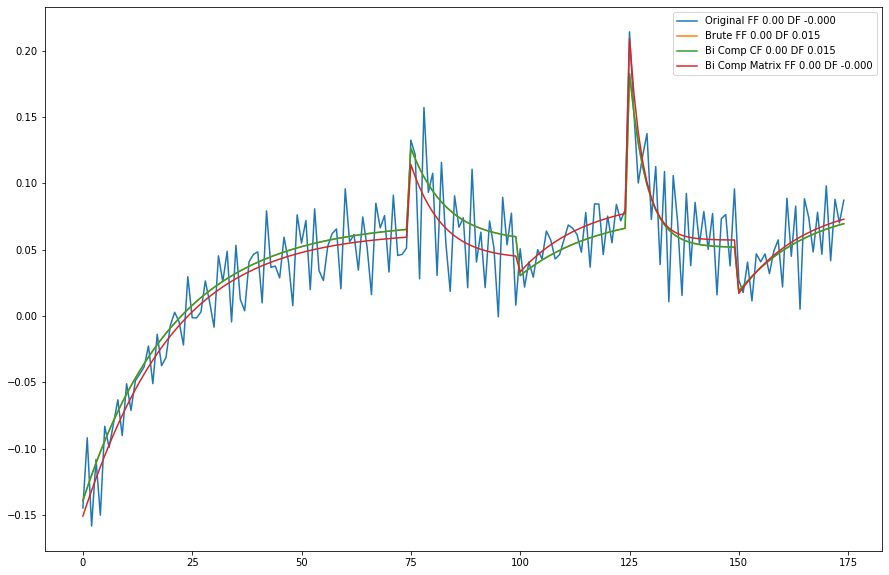

In [9]:
j=np.random.choice(nb_signals)
#j=8
metric=np.real
plt.figure(figsize=(15,10))
plt.plot(metric(all_signals[:,j]),label="Original FF {0:.2f} DF {1:.3f}".format(ff_gt[j],df_gt[j]))
plt.plot(metric(matched_signals_brute[:,j]),label="Brute FF {0:.2f} DF {1:.3f}".format(all_maps_brute[0][0]["ff"][j],all_maps_brute[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_cf[:,j]),label="Bi Comp CF {0:.2f} DF {1:.3f}".format(all_maps_bc_cf[0][0]["ff"][j],all_maps_bc_cf[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_matrix[:,j]),label="Bi Comp Matrix FF {0:.2f} DF {1:.3f}".format(all_maps_bc_matrix[0][0]["ff"][j],all_maps_bc_matrix[0][0]["df"][j]))
plt.legend()

In [10]:
correls_bc_matrix=[]
correls_bc_cf=[]
correls_brute=[]
correls_bc_cf_gpu=[]
correls_bc_matrix_gpu=[]

correls_brute=[]
for i in range(nb_signals):
    correls_bc_matrix.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_matrix[:,i]))[0,1])
    correls_bc_matrix_gpu.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_matrix_gpu[:,i]))[0,1])
    correls_brute.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_brute[:,i]))[0,1])
    correls_bc_cf.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_cf[:,i]))[0,1])
    correls_bc_cf_gpu.append(np.real(np.corrcoef(all_signals[:,i],matched_signals_bc_cf_gpu[:,i]))[0,1])
    
correls_bc_matrix=np.array(correls_bc_matrix)
correls_bc_cf=np.array(correls_bc_cf)
correls_bc_matrix_gpu=np.array(correls_bc_matrix_gpu)
correls_bc_cf_gpu=np.array(correls_bc_cf_gpu)
correls_brute=np.array(correls_brute)
df_correls = pd.DataFrame(columns=["Brute","BC Matrix","BC CF","BC Matrix GPU","BC CF GPU"],data=np.stack([correls_brute,correls_bc_matrix,correls_bc_cf,correls_bc_matrix_gpu,correls_bc_cf_gpu],axis=-1))

In [11]:
df_correls.describe()

,Brute,BC Matrix,BC CF,BC Matrix GPU,BC CF GPU
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.745928,0.746211,0.745939,0.743315,0.745939
std,0.100175,0.100267,0.100175,0.100706,0.100175
min,0.358898,0.358815,0.358815,0.356853,0.358815
25%,0.679136,0.679349,0.679100,0.676137,0.679100
50%,0.758554,0.758705,0.758587,0.755378,0.758587
75%,0.820145,0.821193,0.820151,0.818312,0.820151
max,0.956532,0.956550,0.956547,0.956252,0.956547


In [12]:
np.argmin(df_correls["BC CF"])

548

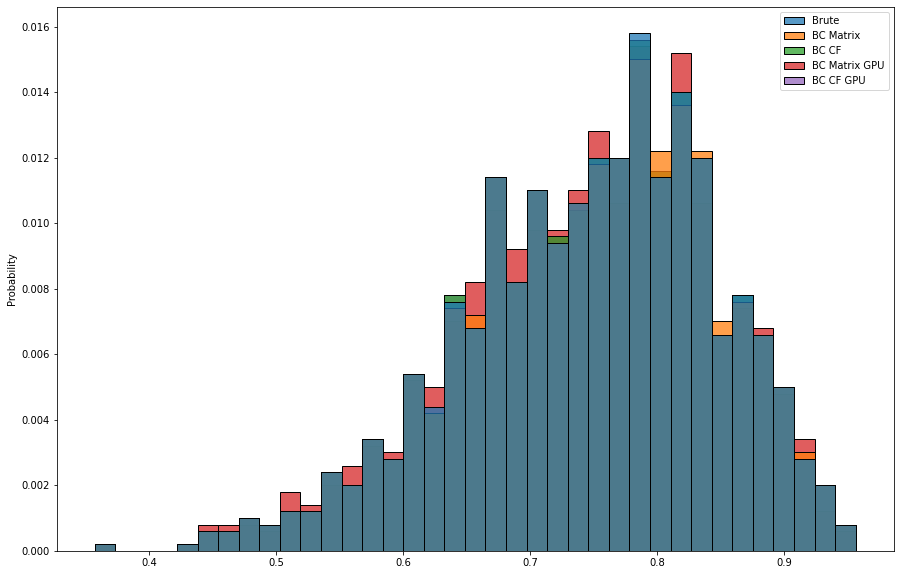

In [13]:
import seaborn as sns
plt.figure(figsize=(15,10))
#df_correls, hist = False, kde = True,
#                 kde_kws = {'shade': True, 'linewidth': 3})

sns.histplot(df_correls,stat="probability");

In [14]:
paramMap

{'wT1': array([1800., 1800., 1800., ...,  800.,  800.,  800.]),
 'wT2': array([40., 40., 40., ..., 40., 40., 40.]),
 'fT1': array([300., 300., 300., ..., 300., 300., 300.]),
 'fT2': array([80., 80., 80., ..., 80., 80., 80.]),
 'attB1': array([0.9, 0.9, 0.9, ..., 1. , 1. , 1. ]),
 'df': array([-0.06, -0.06, -0.06, ..., -0.  , -0.  , -0.  ]),
 'ff': array([0.75, 0.75, 0.75, ..., 0.  , 0.  , 0.  ])}

In [15]:
data_ff=pd.DataFrame(data=np.stack([paramMap["ff"][ind],all_maps_brute[0][0]["ff"],all_maps_bc_cf[0][0]["ff"],all_maps_bc_matrix[0][0]["ff"],all_maps_bc_cf_gpu[0][0]["ff"],all_maps_bc_matrix_gpu[0][0]["ff"]],axis=-1),columns=["FF Truth","FF Brute","FF CF","FF Matrix","FF CF GPU","FF Matrix GPU"])
data_df=pd.DataFrame(data=np.stack([paramMap["df"][ind],all_maps_brute[0][0]["df"],all_maps_bc_cf[0][0]["df"],all_maps_bc_matrix[0][0]["df"],all_maps_bc_cf_gpu[0][0]["df"],all_maps_bc_matrix_gpu[0][0]["df"]],axis=-1),columns=["DF Truth","DF Brute","DF CF","DF Matrix","DF CF GPU","DF Matrix GPU"])
data_wt1=pd.DataFrame(data=np.stack([paramMap["wT1"][ind],all_maps_brute[0][0]["wT1"],all_maps_bc_cf[0][0]["wT1"],all_maps_bc_matrix[0][0]["wT1"],all_maps_bc_cf_gpu[0][0]["wT1"],all_maps_bc_matrix_gpu[0][0]["wT1"]],axis=-1),columns=["T1 Truth","T1 Brute","T1 CF","T1 Matrix","T1 CF GPU","T1 Matrix GPU"])
data_attB1=pd.DataFrame(data=np.stack([paramMap["attB1"][ind],all_maps_brute[0][0]["attB1"],all_maps_bc_cf[0][0]["attB1"],all_maps_bc_matrix[0][0]["attB1"],all_maps_bc_cf_gpu[0][0]["attB1"],all_maps_bc_matrix_gpu[0][0]["attB1"]],axis=-1),columns=["B1 Truth","B1 Brute","B1 CF","B1 Matrix","B1 CF GPU","B1 Matrix GPU"])


data=pd.concat([data_df,data_ff,data_wt1,data_attB1],axis=1)

cols_df=[col for col in data.columns if "DF" in col]
df_min=data.describe()[cols_df].loc["min",:].min()
df_max=data.describe()[cols_df].loc["max",:].max()
cols_b1=[col for col in data.columns if "B1" in col]
b1_min=data.describe()[cols_b1].loc["min",:].min()
b1_max=data.describe()[cols_b1].loc["max",:].max()
cols_T1=[col for col in data.columns if "T1" in col]
T1_min=data.describe()[cols_T1].loc["min",:].min()
T1_max=data.describe()[cols_T1].loc["max",:].max()

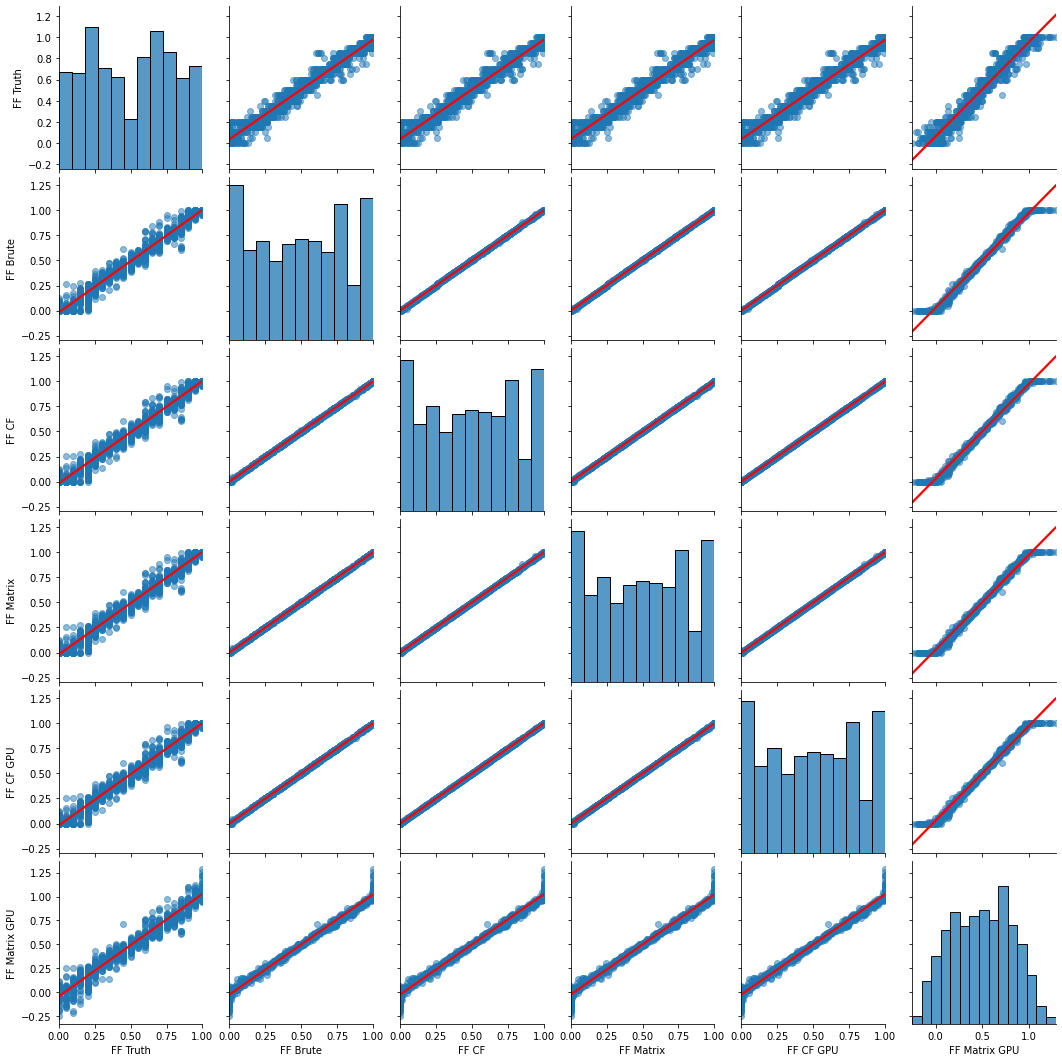

In [16]:
sns.pairplot(data_ff,kind='reg',plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.5}})

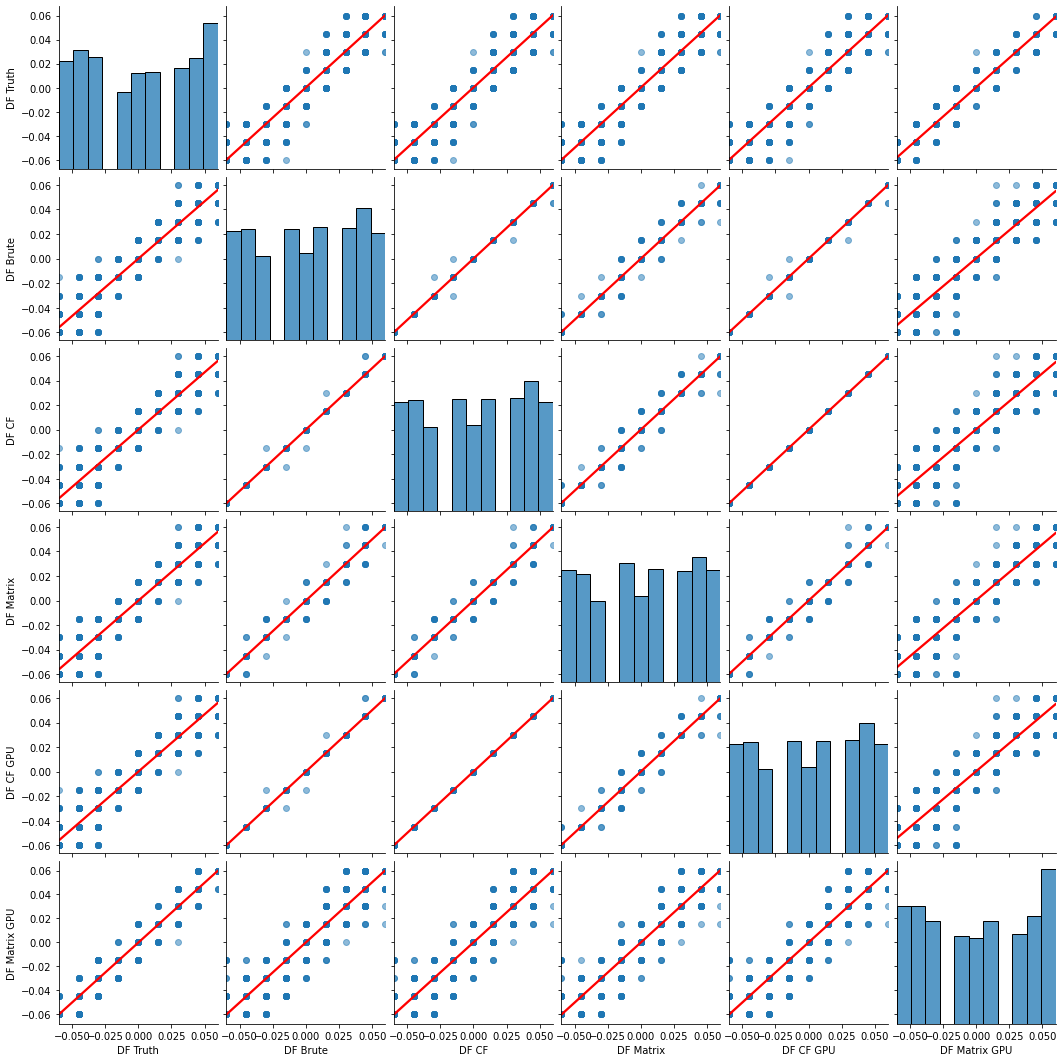

In [17]:
sns.pairplot(data_df,kind='reg',plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.5}})

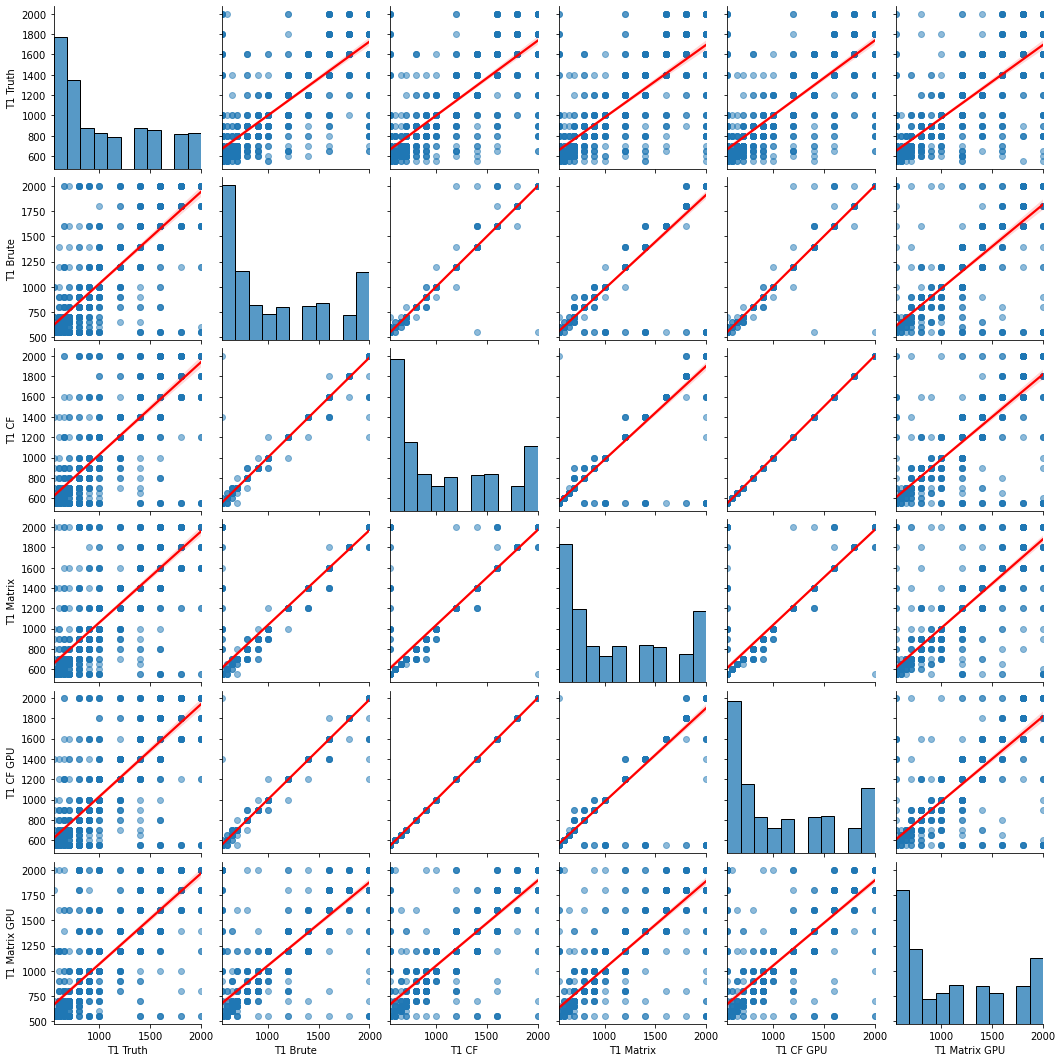

In [18]:
sns.pairplot(data_wt1,kind='reg',plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.5}})

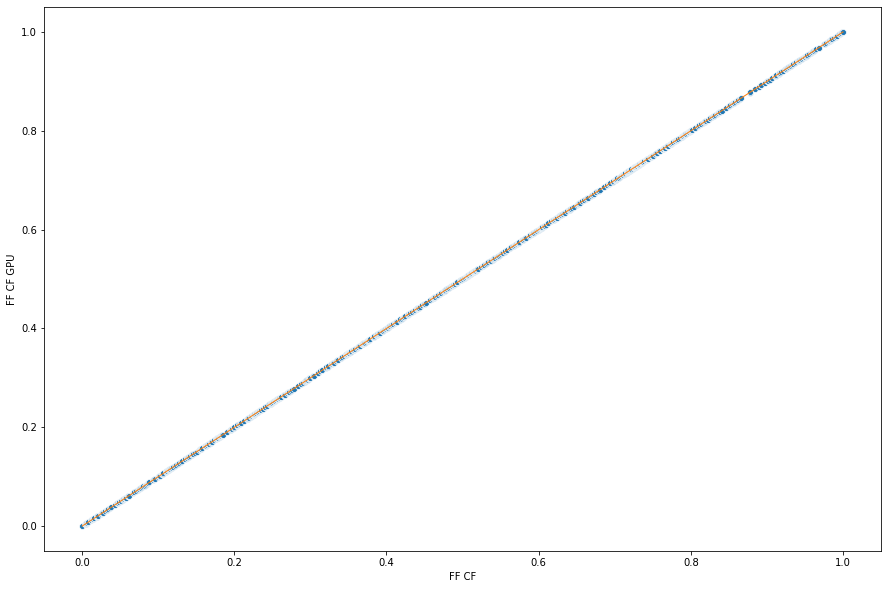

In [19]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF CF",y="FF CF GPU",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

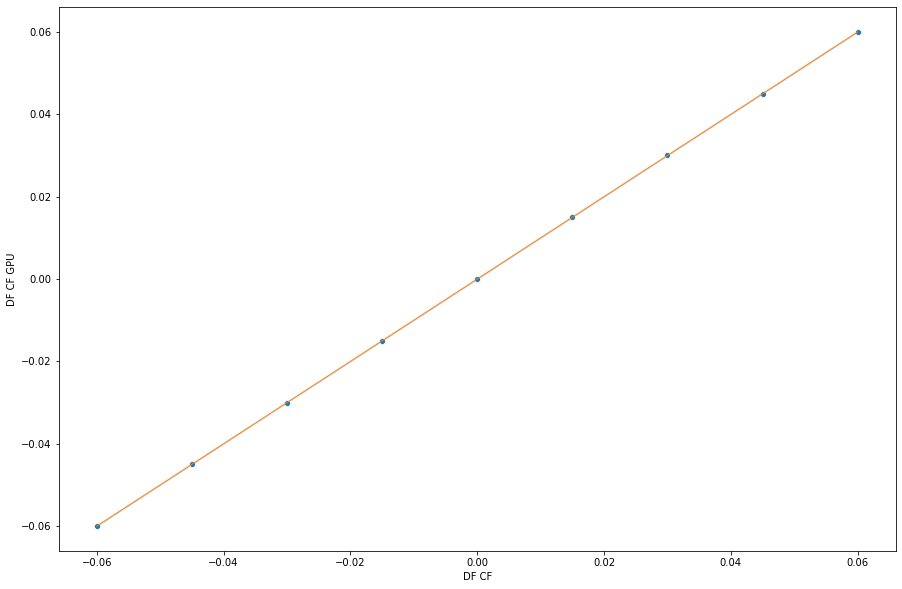

In [20]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF CF",y="DF CF GPU",marker='o', linestyle='')
plt.plot([df_min,df_max], [df_min,df_max], linewidth=1)

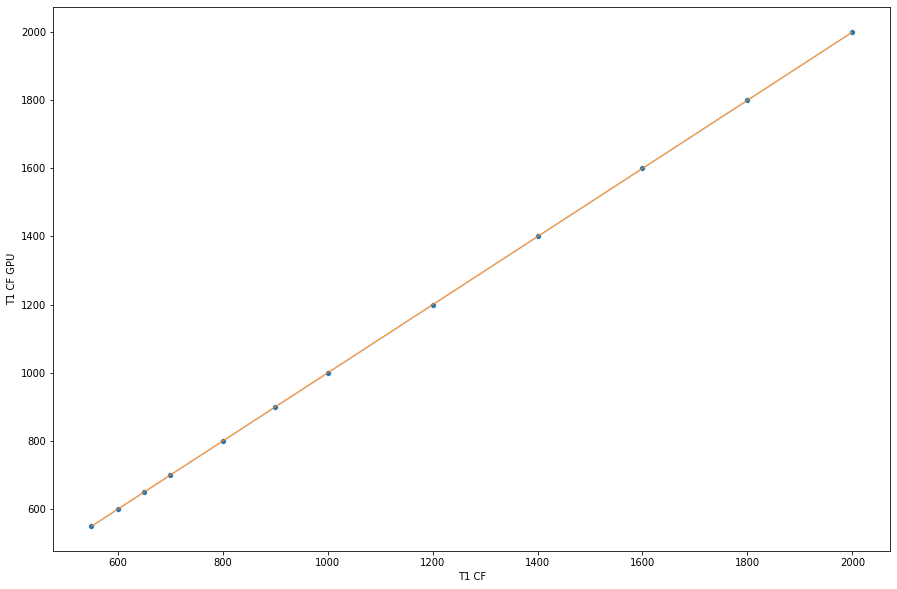

In [21]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="T1 CF",y="T1 CF GPU",marker='o', linestyle='')
plt.plot([T1_min,T1_max], [T1_min,T1_max], linewidth=1)

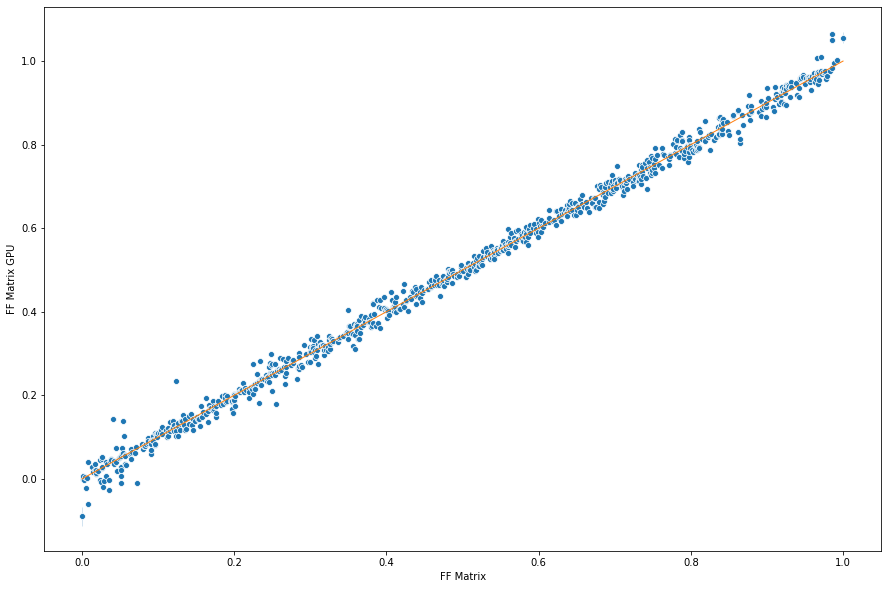

In [47]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Matrix",y="FF Matrix GPU",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

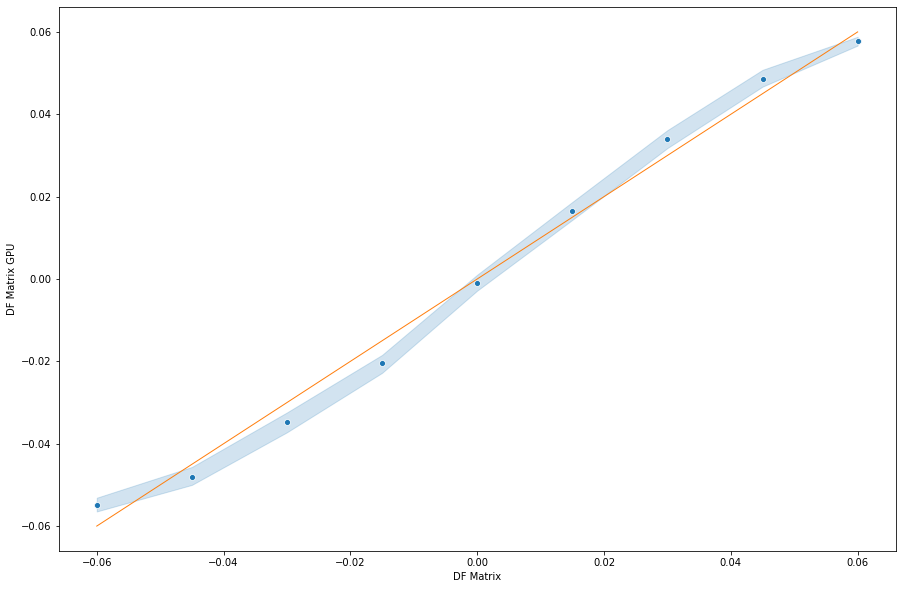

In [48]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Matrix",y="DF Matrix GPU",marker='o', linestyle='')
plt.plot([df_min,df_max], [df_min,df_max], linewidth=1)

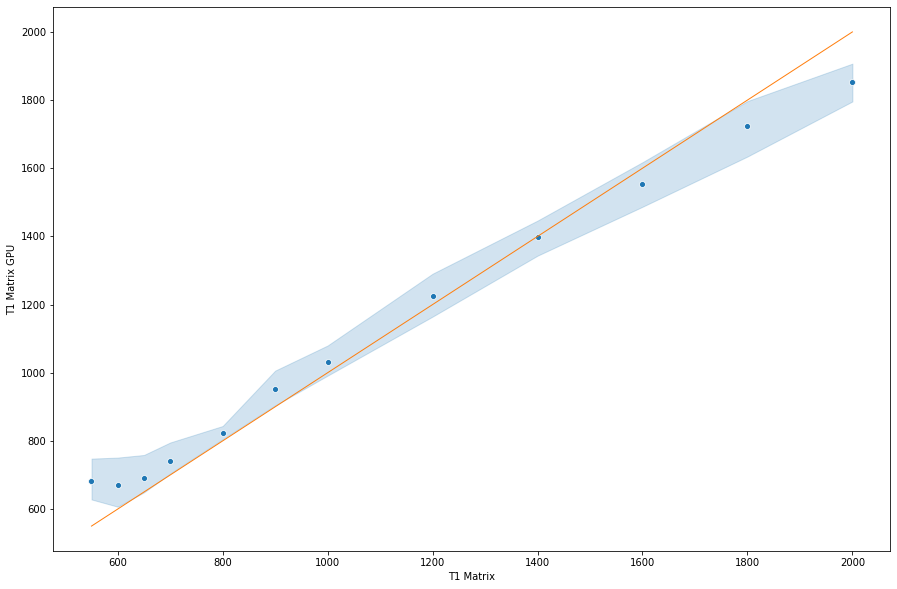

In [49]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="T1 Matrix",y="T1 Matrix GPU",marker='o', linestyle='')
plt.plot([T1_min,T1_max], [T1_min,T1_max], linewidth=1)

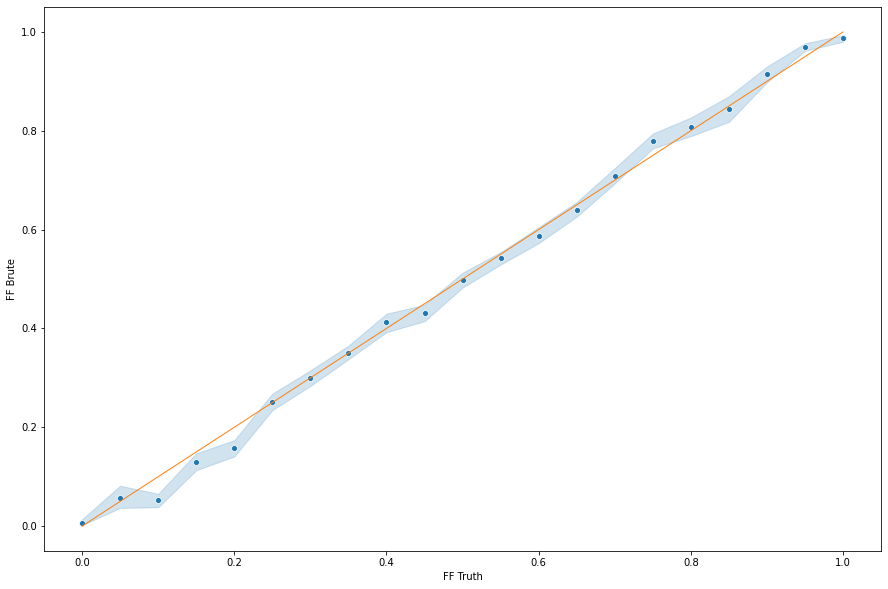

In [23]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Truth",y="FF Brute",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

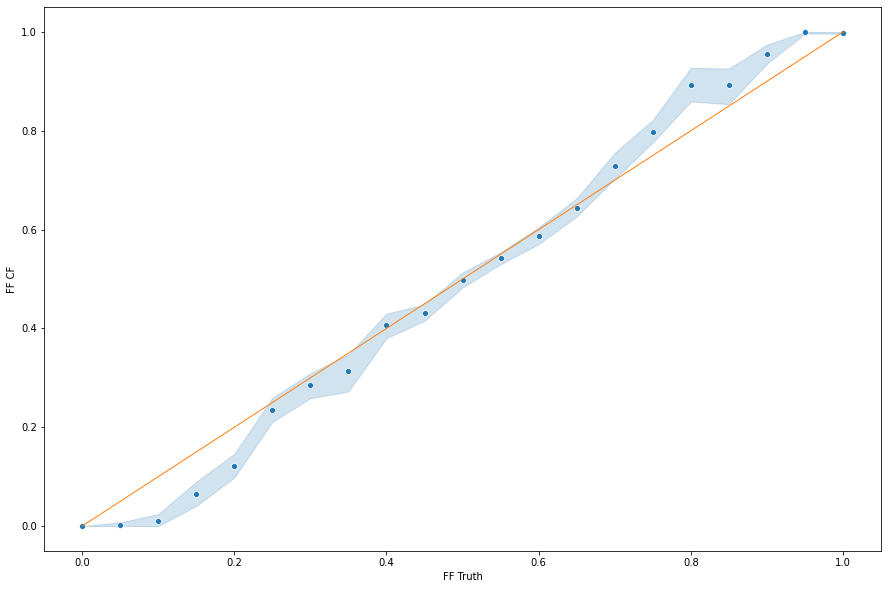

In [24]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Truth",y="FF CF",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

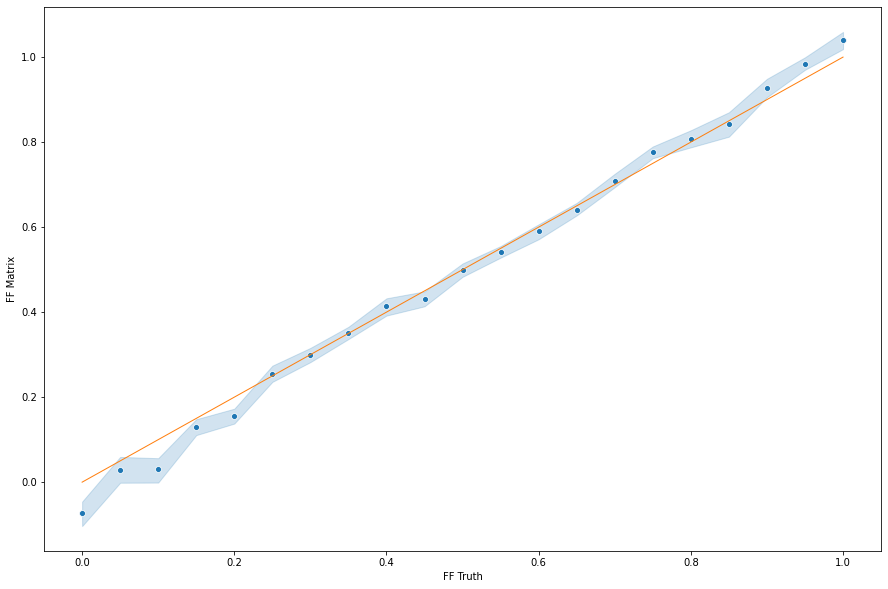

In [25]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Truth",y="FF Matrix",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

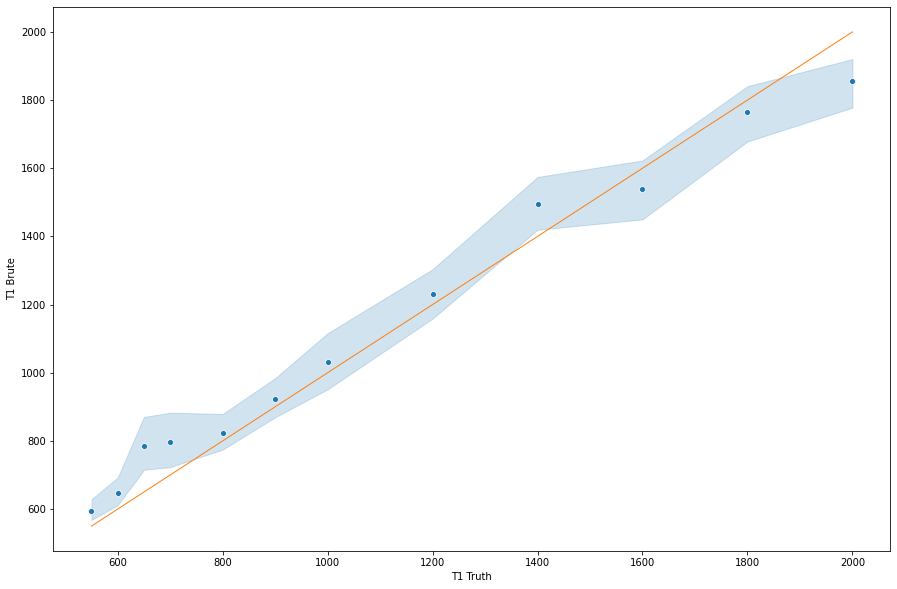

In [26]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="T1 Truth",y="T1 Brute",marker='o', linestyle='')
plt.plot([T1_min, T1_max], [T1_min, T1_max], linewidth=1)

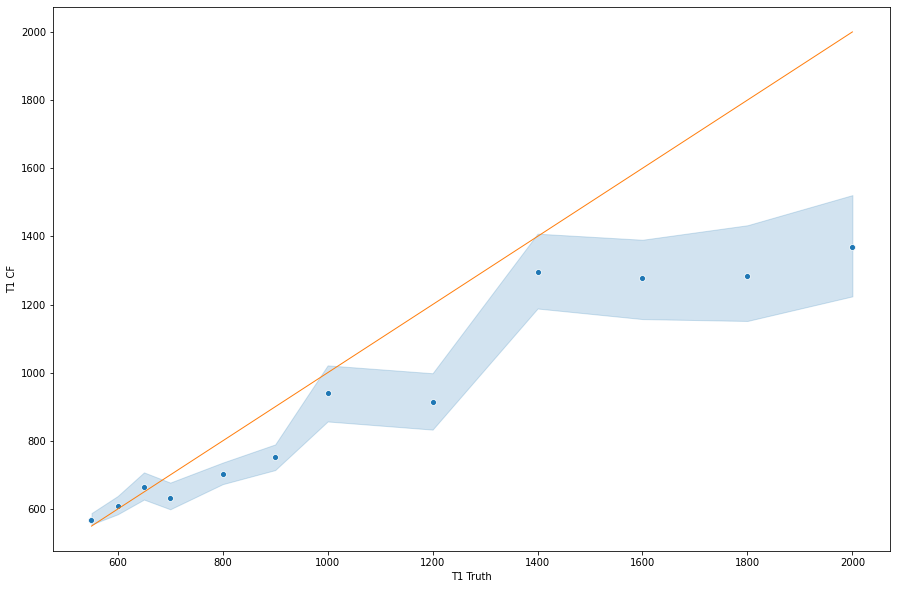

In [27]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="T1 Truth",y="T1 CF",marker='o', linestyle='')
plt.plot([T1_min, T1_max], [T1_min, T1_max], linewidth=1)

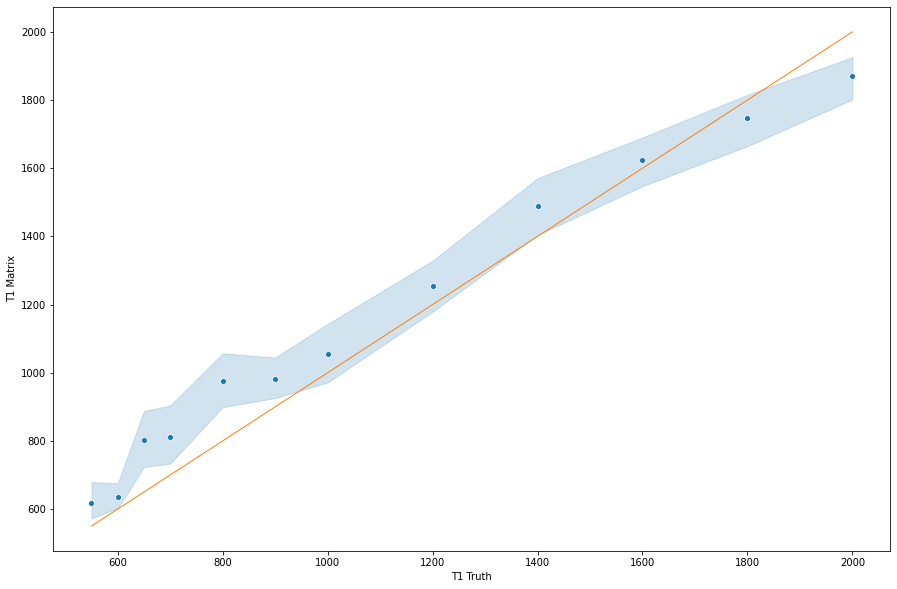

In [28]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="T1 Truth",y="T1 Matrix",marker='o', linestyle='')
plt.plot([T1_min, T1_max], [T1_min, T1_max], linewidth=1)

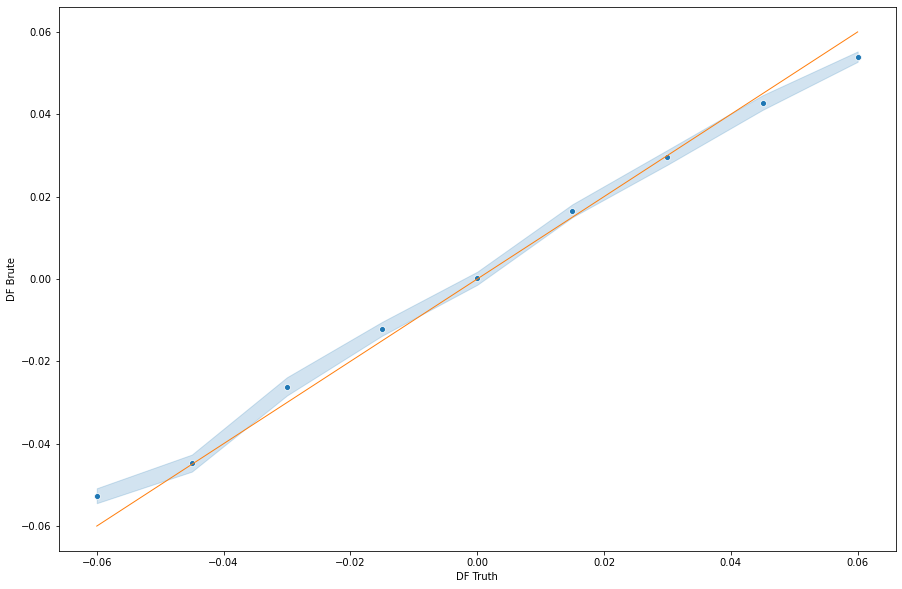

In [26]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Truth",y="DF Brute",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

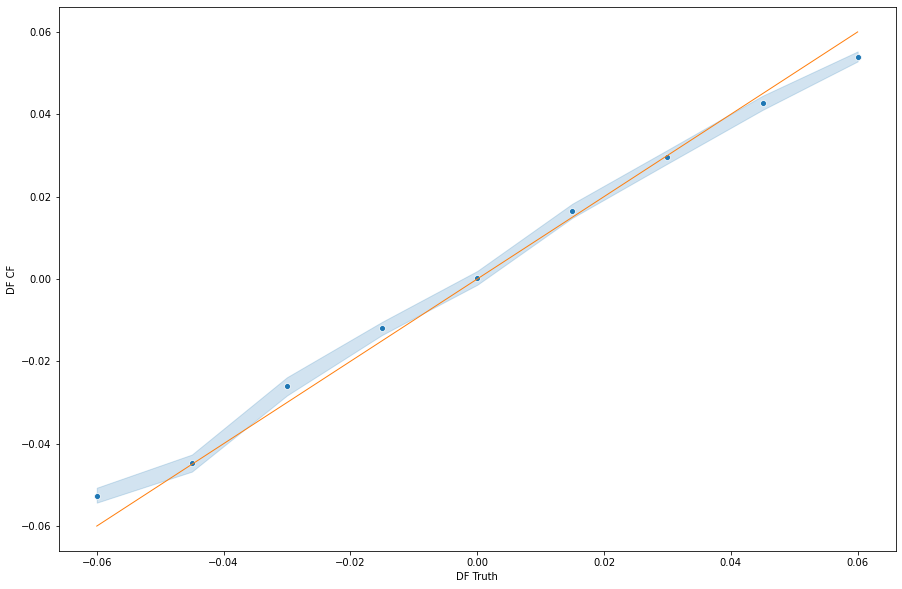

In [27]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Truth",y="DF CF",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

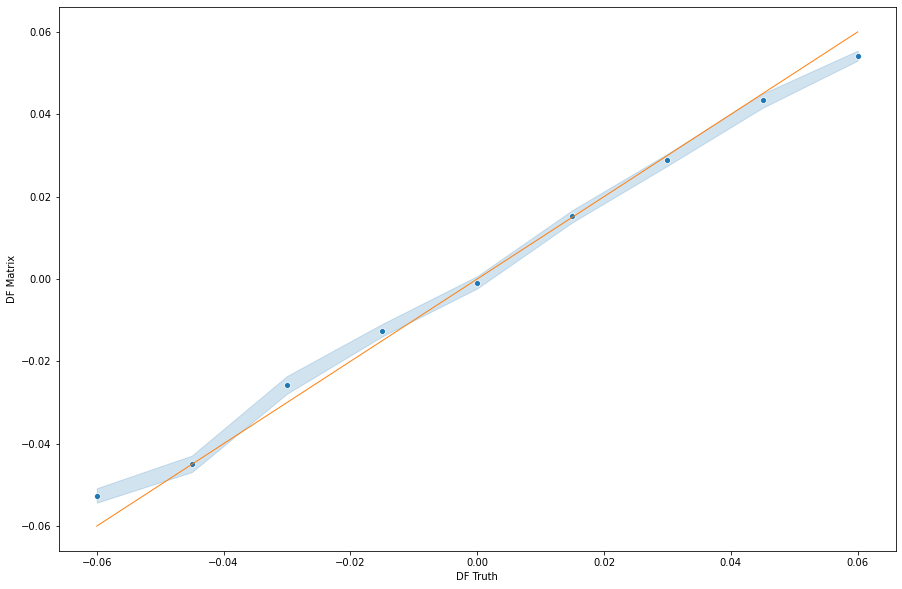

In [28]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Truth",y="DF Matrix",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

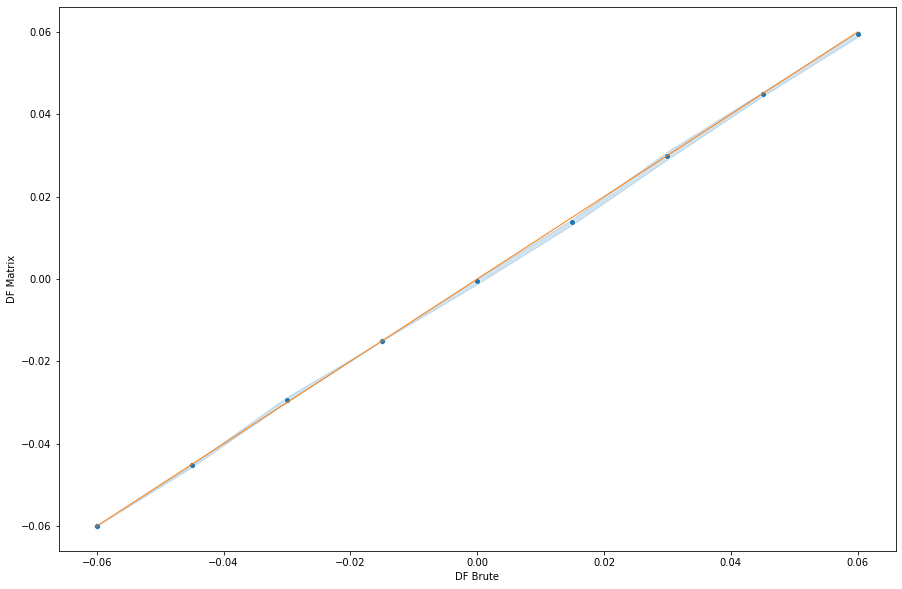

In [29]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Brute",y="DF Matrix",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

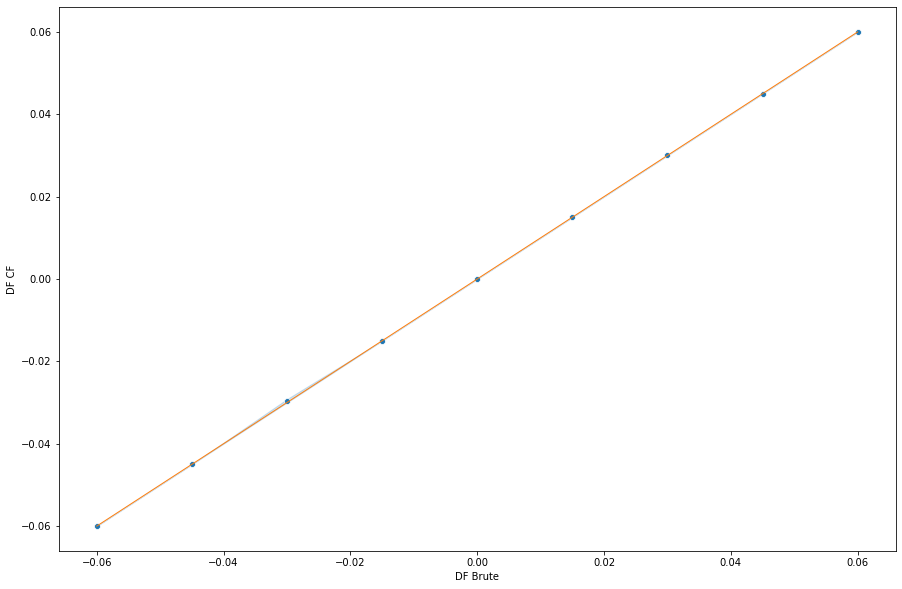

In [30]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF Brute",y="DF CF",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

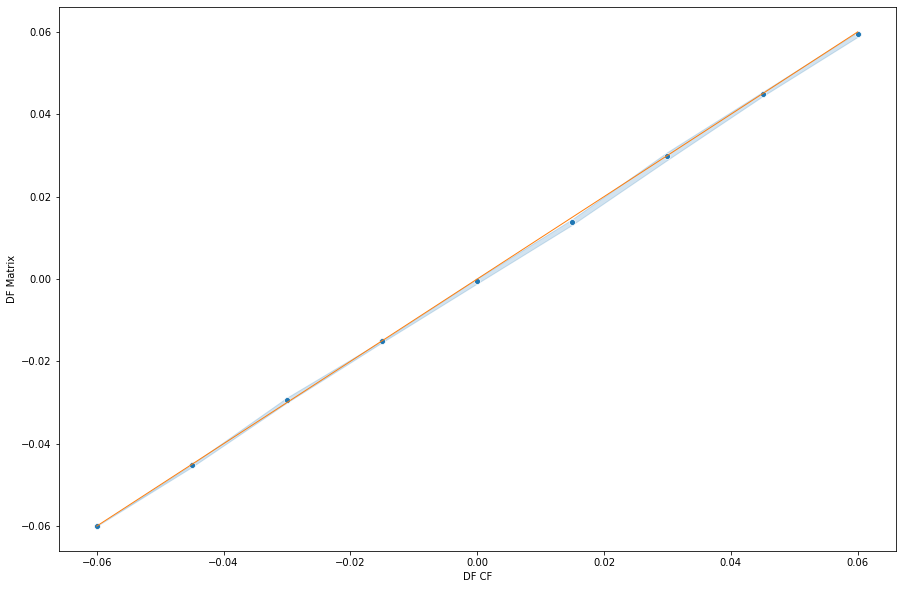

In [31]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="DF CF",y="DF Matrix",marker='o', linestyle='')
plt.plot([df_min, df_max], [df_min, df_max], linewidth=1)

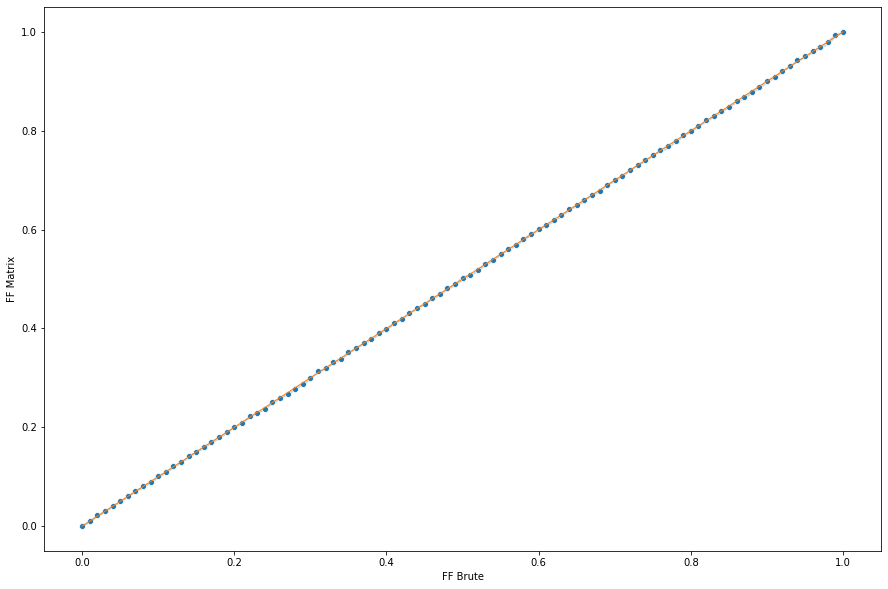

In [32]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Brute",y="FF Matrix",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

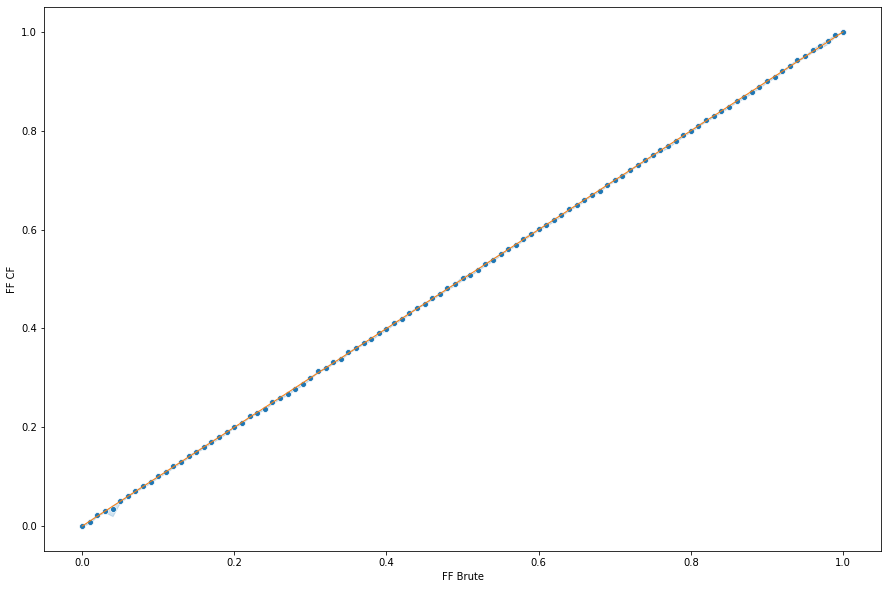

In [33]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Brute",y="FF CF",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

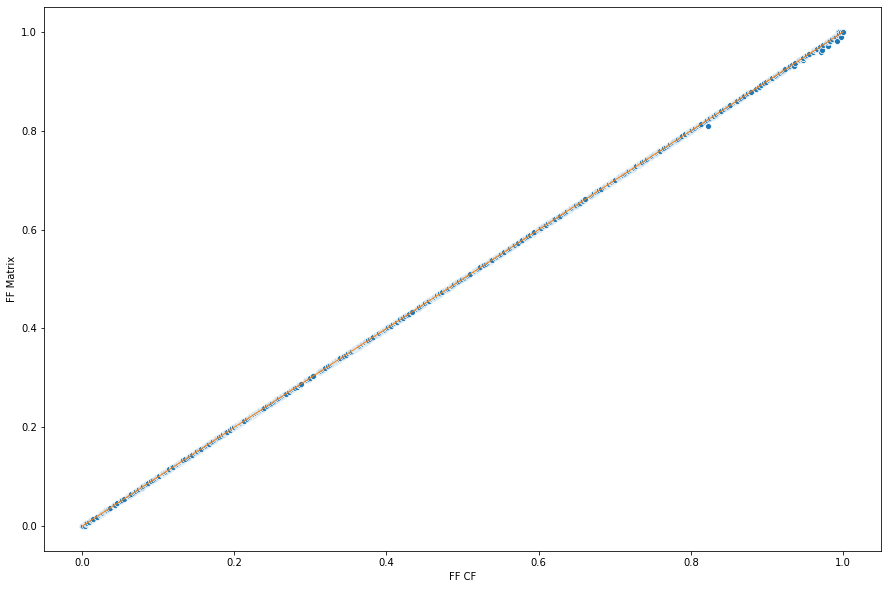

In [34]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF CF",y="FF Matrix",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

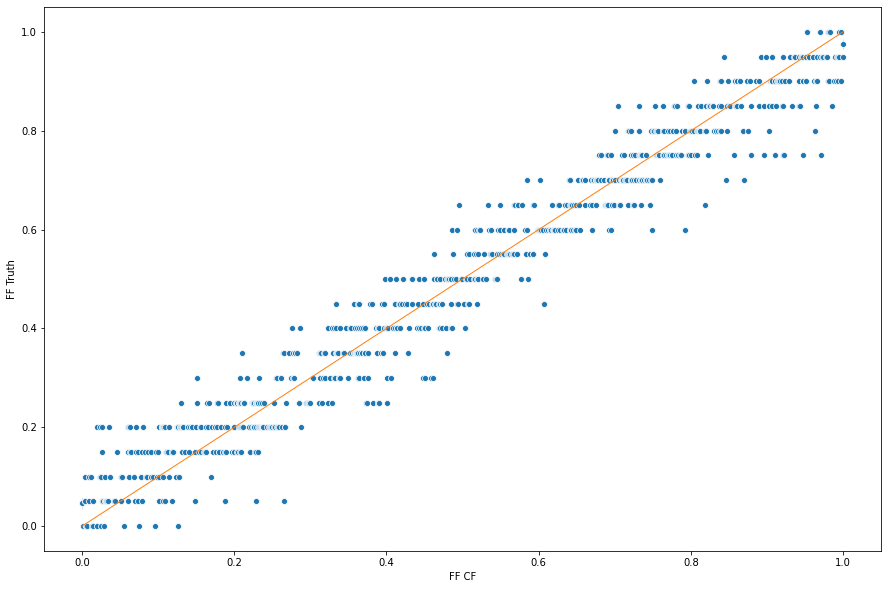

In [35]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF CF",y="FF Truth",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

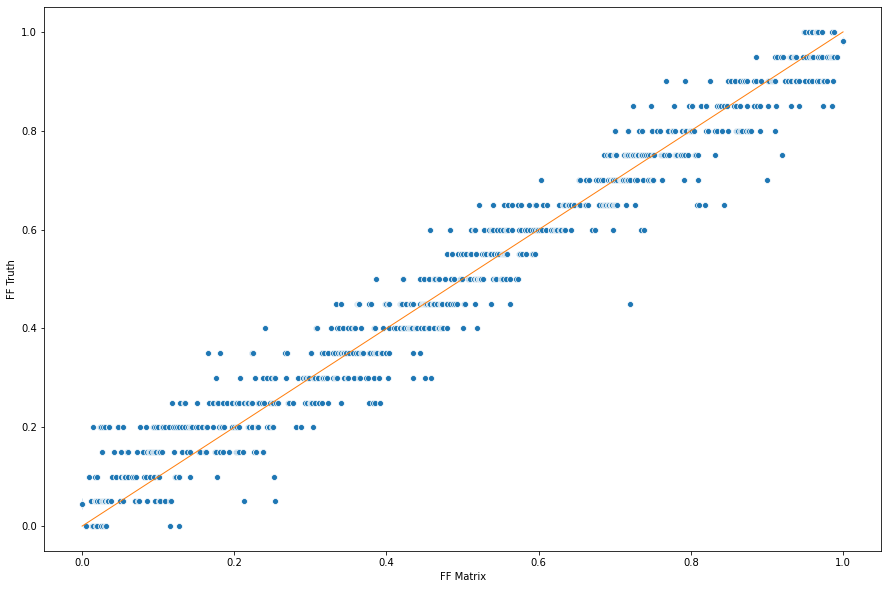

In [84]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data,x="FF Matrix",y="FF Truth",marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linewidth=1)

 ### Debug

In [203]:
j=504
#j=503

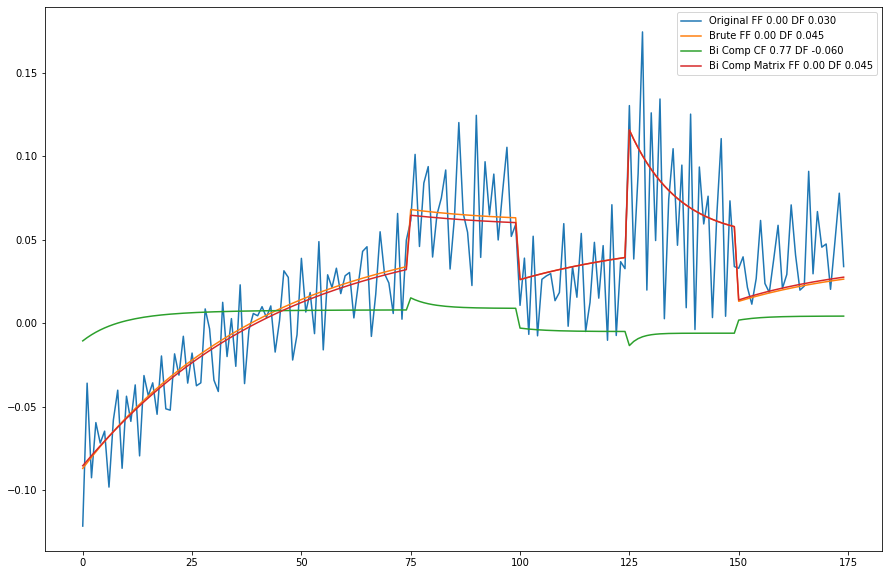

In [204]:
#j=np.random.choice(nb_signals)
metric=np.real
plt.figure(figsize=(15,10))
plt.plot(metric(all_signals[:,j]),label="Original FF {0:.2f} DF {1:.3f}".format(ff_gt[j],df_gt[j]))
plt.plot(metric(matched_signals_brute[:,j]),label="Brute FF {0:.2f} DF {1:.3f}".format(all_maps_brute[0][0]["ff"][j],all_maps_brute[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_cf[:,j]),label="Bi Comp CF {0:.2f} DF {1:.3f}".format(all_maps_bc_cf[0][0]["ff"][j],all_maps_bc_cf[0][0]["df"][j]))
plt.plot(metric(matched_signals_bc_matrix[:,j]),label="Bi Comp Matrix FF {0:.2f} DF {1:.3f}".format(all_maps_bc_matrix[0][0]["ff"][j],all_maps_bc_matrix[0][0]["df"][j]))
plt.legend()

In [205]:
signals=all_signals[:,j].reshape(-1,1)

In [206]:
norm_signals = np.linalg.norm(signals, 2, axis=0)
normed_signals = signals / norm_signals

mrfdict = dictsearch.Dictionary()
mrfdict.load(dictfile, force=True)

keys = mrfdict.keys
array_water = mrfdict.values[:, :, 0]
array_fat = mrfdict.values[:, :, 1]
del mrfdict

array_water_unique, index_water_unique = np.unique(array_water, axis=0, return_inverse=True)
array_fat_unique, index_fat_unique = np.unique(array_fat, axis=0, return_inverse=True)

nb_water_timesteps = array_water_unique.shape[1]
nb_fat_timesteps = array_fat_unique.shape[1]

In [207]:
pca_water = PCAComplex(n_components_=threshold_pca_bc)
pca_fat = PCAComplex(n_components_=threshold_pca_bc)

pca_water.fit(array_water_unique)
pca_fat.fit(array_fat_unique)

transformed_array_water_unique = pca_water.transform(array_water_unique)
transformed_array_fat_unique = pca_fat.transform(array_fat_unique)

In [208]:
var_w = np.sum(array_water_unique * array_water_unique.conj(), axis=1).real
var_f = np.sum(array_fat_unique * array_fat_unique.conj(), axis=1).real
sig_wf = np.sum(array_water_unique[index_water_unique] * array_fat_unique[index_fat_unique].conj(), axis=1).real

var_w = var_w[index_water_unique]
var_f = var_f[index_fat_unique]

var_w = np.reshape(var_w, (-1, 1))
var_f = np.reshape(var_f, (-1, 1))
sig_wf = np.reshape(sig_wf, (-1, 1))

In [209]:
nb_signals = normed_signals.shape[1]
num_group = int(nb_signals / split) + 1

idx_max_all_unique = []
alpha_optim = []

In [147]:
for j in tqdm(range(num_group)):
    j_signal = j * split
    j_signal_next = np.minimum((j + 1) * split, nb_signals)
    transformed_all_signals_water = np.transpose(
                    pca_water.transform(np.transpose(normed_signals[:, j_signal:j_signal_next])))
    transformed_all_signals_fat = np.transpose(
                    pca_fat.transform(np.transpose(normed_signals[:, j_signal:j_signal_next])))

    sig_ws_all_unique = np.matmul(transformed_array_water_unique,
                                              transformed_all_signals_water.conj())
    sig_fs_all_unique = np.matmul(transformed_array_fat_unique,
                                              transformed_all_signals_fat.conj())
    
    current_sig_ws_for_phase = sig_ws_all_unique[index_water_unique, :]
    current_sig_fs_for_phase = sig_fs_all_unique[index_fat_unique, :]
    
    A = sig_wf * current_sig_ws_for_phase - var_w * current_sig_fs_for_phase
    B = (
                        current_sig_ws_for_phase + current_sig_fs_for_phase) * sig_wf - var_w * current_sig_fs_for_phase - var_f * current_sig_ws_for_phase

    a = B.real * current_sig_fs_for_phase.real + B.imag * current_sig_fs_for_phase.imag - B.imag * current_sig_ws_for_phase.imag - B.real * current_sig_ws_for_phase.real
    b = A.real * current_sig_ws_for_phase.real + A.imag * current_sig_ws_for_phase.imag + B.imag * current_sig_ws_for_phase.imag + B.real * current_sig_ws_for_phase.real - A.imag * current_sig_fs_for_phase.imag - A.real * current_sig_fs_for_phase.real
    c = -A.real * current_sig_ws_for_phase.real - A.imag * current_sig_ws_for_phase.imag

    discr = b ** 2 - 4 * a * c
    alpha1 = (-b + np.sqrt(discr)) / (2 * a)
    alpha2 = (-b - np.sqrt(discr)) / (2 * a)
    current_alpha_all_unique = (1 * (alpha1 >= 0) & (alpha1 <= 1)) * alpha1 + (
                    1 - (1 * (alpha1 >= 0) & (alpha1 <= 1))) * alpha2
    
    apha_more_0=(current_alpha_all_unique>=0)
    alpha_less_1=(current_alpha_all_unique<=1)
    alpha_out_bounds=(1*(apha_more_0))*(1*(alpha_less_1))==0
    d_oobounds_0 = current_sig_ws_for_phase[alpha_out_bounds]
    phase_adj_0 = -np.arctan(d_oobounds_0.imag / d_oobounds_0.real)
    cond = np.sin(phase_adj_0) * d_oobounds_0.imag - np.cos(phase_adj_0) * d_oobounds_0.real
    phase_adj_0 = (phase_adj_0) * (
                    1 * (cond) <= 0) + (phase_adj_0 + np.pi) * (
                                1 * (cond) > 0)
    current_sig_ws_0 = (current_sig_ws_for_phase[alpha_out_bounds] * np.exp(1j * phase_adj_0)).real
    J_0=current_sig_ws_0/np.sqrt(np.squeeze(var_w[np.argwhere(alpha_out_bounds)[:,0]]))

    d_oobounds_1 = current_sig_fs_for_phase[alpha_out_bounds]
    phase_adj_1 = -np.arctan(d_oobounds_1.imag / d_oobounds_1.real)
    cond = np.sin(phase_adj_1) * d_oobounds_1.imag - np.cos(phase_adj_1) * d_oobounds_1.real
    phase_adj_1 = (phase_adj_1) * (
                    1 * (cond) <= 0) + (phase_adj_1 + np.pi) * (
                                  1 * (cond) > 0)
    
    current_sig_fs_1 = (current_sig_fs_for_phase[alpha_out_bounds] * np.exp(1j * phase_adj_1)).real
    J_1 = current_sig_fs_1 / np.sqrt(np.squeeze(var_f[np.argwhere(alpha_out_bounds)[:,0]]))

    
    current_alpha_all_unique[alpha_out_bounds]=np.argmax(np.concatenate([J_0[:, None], J_1[:, None]], axis=-1), axis=-1).astype("float")


    d = (
                        1 - current_alpha_all_unique) * current_sig_ws_for_phase + current_alpha_all_unique * current_sig_fs_for_phase
    phase_adj = -np.arctan(d.imag / d.real)
    cond = np.sin(phase_adj) * d.imag - np.cos(phase_adj) * d.real
    
    phase_adj = (phase_adj) * (
                    1 * (cond) <= 0) + (phase_adj + np.pi) * (
                                1 * (cond) > 0)
    
    current_sig_ws = (current_sig_ws_for_phase * np.exp(1j * phase_adj)).real
    current_sig_fs = (current_sig_fs_for_phase * np.exp(1j * phase_adj)).real
    J_all = ((
                             1 - current_alpha_all_unique) * current_sig_ws + current_alpha_all_unique * current_sig_fs) / np.sqrt(
                (
                        1 - current_alpha_all_unique) ** 2 * var_w + current_alpha_all_unique ** 2 * var_f + 2 * current_alpha_all_unique * (
                        1 - current_alpha_all_unique) * sig_wf)
    
    idx_max_all_current = np.argmax(J_all, axis=0)

100%|██████████| 1/1 [00:00<00:00, 431.96it/s]


In [164]:
alpha_out_bounds

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [165]:
J_all.shape

(864, 1)

In [166]:
current_alpha_all_unique

array([[0.53563517],
       [0.51915379],
       [0.50367298],
       [0.48894493],
       [0.47472369],
       [0.46076904],
       [0.4468476 ],
       [0.43273264],
       [0.41820348],
       [0.52105952],
       [0.50388493],
       [0.48777728],
       [0.47247548],
       [0.45772119],
       [0.44326274],
       [0.42885622],
       [0.41426534],
       [0.39926084],
       [0.50551273],
       [0.48761726],
       [0.47087063],
       [0.45499521],
       [0.43971743],
       [0.42477172],
       [0.40990148],
       [0.39485881],
       [0.37940382],
       [0.49042416],
       [0.47186008],
       [0.45453917],
       [0.43816458],
       [0.42244547],
       [0.4071007 ],
       [0.3918596 ],
       [0.37646134],
       [0.36065406],
       [0.47681599],
       [0.4576903 ],
       [0.43991065],
       [0.42315911],
       [0.40712635],
       [0.39151497],
       [0.37603966],
       [0.3604262 ],
       [0.34441021],
       [0.46524579],
       [0.44569064],
       [0.427

In [292]:
for j in tqdm(range(num_group)):
    j_signal = j * split
    j_signal_next = np.minimum((j + 1) * split, nb_signals)
    transformed_all_signals_water = np.transpose(
                    pca_water.transform(np.transpose(normed_signals[:, j_signal:j_signal_next])))
    transformed_all_signals_fat = np.transpose(
                    pca_fat.transform(np.transpose(normed_signals[:, j_signal:j_signal_next])))

    sig_ws_all_unique = np.matmul(transformed_array_water_unique,
                                              transformed_all_signals_water.conj())
    sig_fs_all_unique = np.matmul(transformed_array_fat_unique,
                                              transformed_all_signals_fat.conj())
    
    current_sig_ws_for_phase = sig_ws_all_unique[index_water_unique, :]
    current_sig_fs_for_phase = sig_fs_all_unique[index_fat_unique, :]
    
    A = sig_wf * current_sig_ws_for_phase - var_w * current_sig_fs_for_phase
    B = (
                        current_sig_ws_for_phase + current_sig_fs_for_phase) * sig_wf - var_w * current_sig_fs_for_phase - var_f * current_sig_ws_for_phase

    a = B.real * current_sig_fs_for_phase.real + B.imag * current_sig_fs_for_phase.imag - B.imag * current_sig_ws_for_phase.imag - B.real * current_sig_ws_for_phase.real
    b = A.real * current_sig_ws_for_phase.real + A.imag * current_sig_ws_for_phase.imag + B.imag * current_sig_ws_for_phase.imag + B.real * current_sig_ws_for_phase.real - A.imag * current_sig_fs_for_phase.imag - A.real * current_sig_fs_for_phase.real
    c = -A.real * current_sig_ws_for_phase.real - A.imag * current_sig_ws_for_phase.imag

    discr = b ** 2 - 4 * a * c
    alpha1 = (-b + np.sqrt(discr)) / (2 * a)
    alpha2 = (-b - np.sqrt(discr)) / (2 * a)
    current_alpha_all_unique = (1 * (alpha1 >= 0) & (alpha1 <= 1)) * alpha1 + (
                    1 - (1 * (alpha1 >= 0) & (alpha1 <= 1))) * alpha2
    
    apha_more_0=(current_alpha_all_unique>=0)
    alpha_less_1=(current_alpha_all_unique<=1)
    alpha_out_bounds=(1*(apha_more_0))*(1*(alpha_less_1))==0
    
    d_oobounds_0 = current_sig_ws_for_phase[:]
    phase_adj_0 = -np.arctan(d_oobounds_0.imag / d_oobounds_0.real)
    cond = np.sin(phase_adj_0) * d_oobounds_0.imag - np.cos(phase_adj_0) * d_oobounds_0.real
    phase_adj_0 = (phase_adj_0) * (
                    1 * (cond) <= 0) + (phase_adj_0 + np.pi) * (
                                1 * (cond) > 0)
    current_sig_ws_0 = (current_sig_ws_for_phase[:] * np.exp(1j * phase_adj_0)).real
    J_0=current_sig_ws_0/np.sqrt(var_w)

    d_oobounds_1 = current_sig_fs_for_phase[:]
    phase_adj_1 = -np.arctan(d_oobounds_1.imag / d_oobounds_1.real)
    cond = np.sin(phase_adj_1) * d_oobounds_1.imag - np.cos(phase_adj_1) * d_oobounds_1.real
    phase_adj_1 = (phase_adj_1) * (
                    1 * (cond) <= 0) + (phase_adj_1 + np.pi) * (
                                  1 * (cond) > 0)
    
    current_sig_fs_1 = (current_sig_fs_for_phase[:] * np.exp(1j * phase_adj_1)).real
    J_1 = current_sig_fs_1 / np.sqrt(var_f)

    
    current_alpha_all_unique[alpha_out_bounds]=np.argmax(np.concatenate([J_0[alpha_out_bounds, None], J_1[alpha_out_bounds, None]], axis=-1), axis=-1).astype("float")
#
#
    d = (
                        1 - current_alpha_all_unique) * current_sig_ws_for_phase + current_alpha_all_unique * current_sig_fs_for_phase
    phase_adj = -np.arctan(d.imag / d.real)
    cond = np.sin(phase_adj) * d.imag - np.cos(phase_adj) * d.real
    
    phase_adj = (phase_adj) * (
                    1 * (cond) <= 0) + (phase_adj + np.pi) * (
                                1 * (cond) > 0)
    
    current_sig_ws = (current_sig_ws_for_phase * np.exp(1j * phase_adj)).real
    current_sig_fs = (current_sig_fs_for_phase * np.exp(1j * phase_adj)).real
    J_all = ((
                             1 - current_alpha_all_unique) * current_sig_ws + current_alpha_all_unique * current_sig_fs) / np.sqrt(
                (
                        1 - current_alpha_all_unique) ** 2 * var_w + current_alpha_all_unique ** 2 * var_f + 2 * current_alpha_all_unique * (
                        1 - current_alpha_all_unique) * sig_wf)
    
    
    
    all_J = np.stack([J_all,J_0,J_1],axis=0)
    all_alpha=np.stack([current_alpha_all_unique,np.zeros(current_alpha_all_unique.shape),np.ones(current_alpha_all_unique.shape)],axis=0)
    all_phase=np.stack([phase_adj,phase_adj_0,phase_adj_1],axis=0)
    
    ind_max_J = np.argmax(all_J,axis=0)
    
    J_all = (ind_max_J==0)*J_all + (ind_max_J==1)*J_0+(ind_max_J==2)*J_1
    current_alpha_all_unique = (ind_max_J==0)*current_alpha_all_unique + (ind_max_J==1)*0+(ind_max_J==2)*1
    phase_adj = (ind_max_J==0)*phase_adj + (ind_max_J==1)*phase_adj_0+(ind_max_J==2)*phase_adj_1
    
    #current_alpha_all_unique = all_alpha[np.arange(J_all.shape[0]),np.arange(J_all.shape[1]),ind_max_J]
    #phase_adj = all_phase[np.arange(J_all.shape[0]),np.arange(J_all.shape[1]),ind_max_J]
    
    #J_all=all_J[np.arange(J_all.shape[0]),np.arange(J_all.shape[1]),ind_max_J]
    
    
    
    #idx_max_all_current = np.argmax(J_all, axis=0)

100%|██████████| 1/1 [00:00<00:00, 94.47it/s]


100%|██████████| 101/101 [00:00<00:00, 1831.22it/s]

Max alpha on surface : 0.0
Alpha 1 : 0.95
Alpha 2 : -0.61
Alpha calc : 0.0
Max phi on surface : 0.0
Phi optim: -0.04
Max correl on surface 0.63
Retrieved correl on surface 0.63


<IPython.core.display.Javascript object>


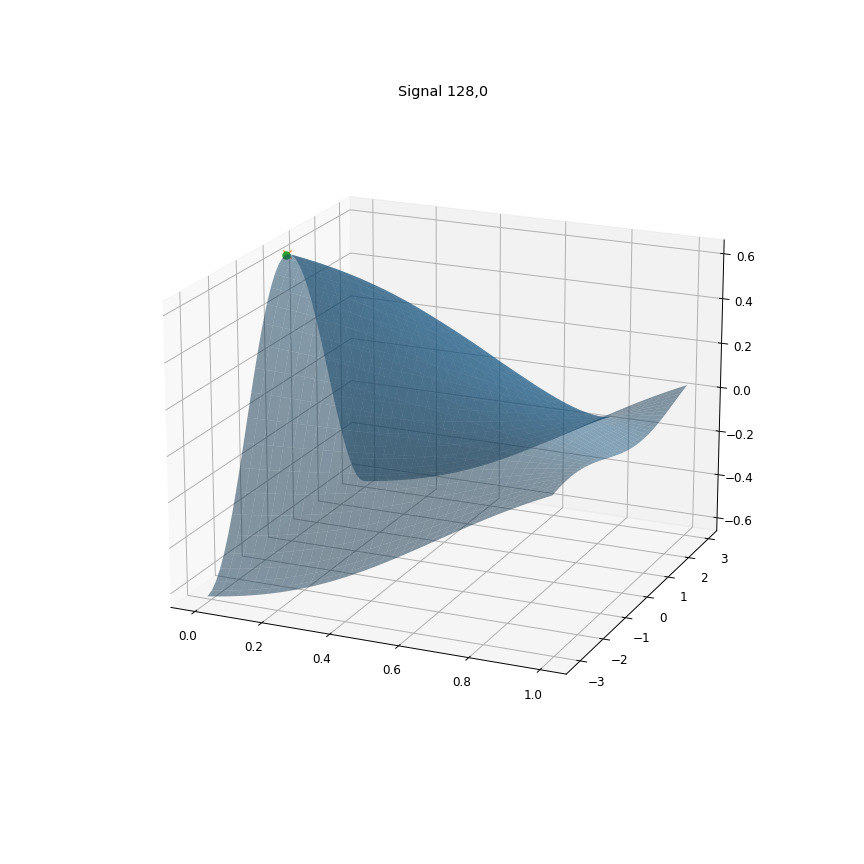

Text(0.5, 0.92, 'Signal 128,0')

In [293]:
%matplotlib notebook

def J_alpha_pixel(alpha,phi, i, j):
    current_sig_ws = (current_sig_ws_for_phase[i,j] * np.exp(1j * phi)).real
    current_sig_fs = (current_sig_fs_for_phase[i,j] * np.exp(1j * phi)).real
    return ((
             1 - alpha) * current_sig_ws + alpha * current_sig_fs) / np.sqrt(
        (
                1 - alpha) ** 2 * var_w[i] + alpha ** 2 * var_f[i] + 2 * alpha * (
                1 - alpha) * sig_wf[i])
phi = np.arange(-np.pi,np.pi,np.pi/20)
alpha = np.arange(0.,1.01,0.01)
alphav_np, phiv_np = np.meshgrid(alpha, phi, sparse=False, indexing='ij')
i_=0
j_=0
s,t=current_sig_ws_for_phase.shape
n,m = alphav_np.shape
result_np=np.zeros(alphav_np.shape)
i_,j_=np.unravel_index(np.random.choice(np.arange(s*t)),(s,t))
for p in tqdm(range(n)):
    for q in range(m):
        result_np[p,q]=J_alpha_pixel(alphav_np[p,q],phiv_np[p,q],i_,j_)
import matplotlib.pyplot as plt
index_min_p,index_min_q = np.unravel_index(np.argmax(result_np), result_np.shape)
alpha_min = alphav_np[index_min_p,index_min_q]
phi_min = phiv_np[index_min_p, index_min_q]
result_min = result_np[index_min_p, index_min_q]
print("Max alpha on surface : {}".format(np.round(alpha_min,2)))
print("Alpha 1 : {}".format(np.round(alpha1[i_,j_],2)))
print("Alpha 2 : {}".format(np.round(alpha2[i_,j_],2)))
print("Alpha calc : {}".format(np.round(current_alpha_all_unique[i_,j_], 2)))
print("Max phi on surface : {}".format(np.round(phi_min, 2)))

print("Phi optim: {}".format(np.round(phase_adj[i_,j_], 2)))
print("Max correl on surface {}".format(np.round(result_min,2)))
print("Retrieved correl on surface {}".format(np.round( J_alpha_pixel(current_alpha_all_unique[i_,j_], phase_adj[i_,j_], i_, j_)[0],2)))



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alphav_np, phiv_np, result_np,alpha=0.5)

ax.plot(alpha_min,phi_min,result_min,marker="x")
ax.plot(current_alpha_all_unique[i_,j_], phase_adj[i_,j_], J_alpha_pixel(current_alpha_all_unique[i_,j_], phase_adj[i_,j_], i_, j_)[0], marker="o")
ax.set_title("Signal {},{}".format(i_,j_))

In [150]:
phi=phi_min

In [151]:
alpha_slice=np.arange(-1,1,0.01)

In [152]:
J_slice = [J_alpha_pixel(a,phi, i_, j_) for a in alpha_slice]

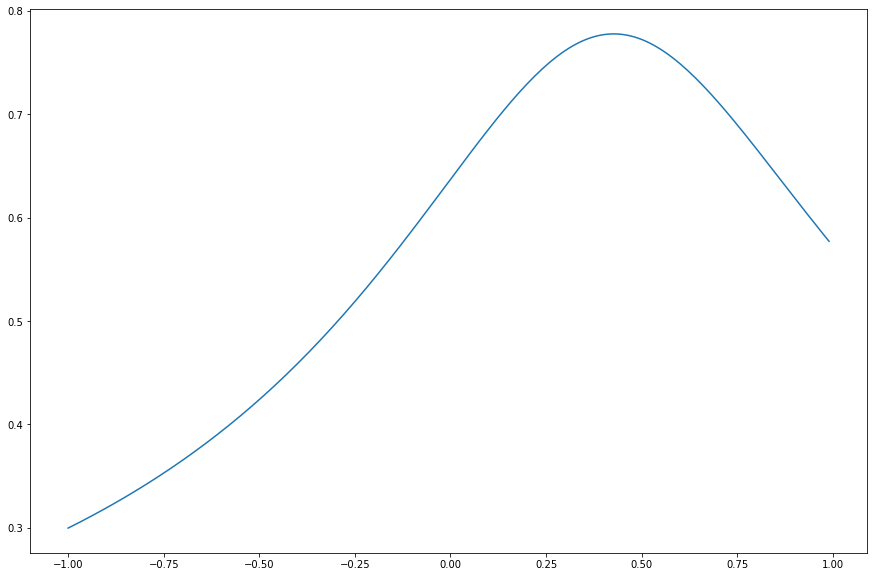

In [153]:
%matplotlib inline 
plt.figure(figsize=(15,10))
plt.plot(alpha_slice,np.array(J_slice).flatten())

In [122]:
np.array(J_slice).flatten()

array([-0.0344024 , -0.03425897, -0.03411317, -0.03396491, -0.03381416,
       -0.03366085, -0.03350493, -0.03334632, -0.03318497, -0.03302081,
       -0.03285377, -0.03268378, -0.03251078, -0.03233469, -0.03215543,
       -0.03197292, -0.03178709, -0.03159785, -0.03140512, -0.0312088 ,
       -0.03100881, -0.03080506, -0.03059745, -0.03038588, -0.03017025,
       -0.02995045, -0.02972638, -0.02949792, -0.02926497, -0.02902739,
       -0.02878508, -0.02853791, -0.02828574, -0.02802845, -0.02776589,
       -0.02749793, -0.02722442, -0.02694522, -0.02666016, -0.02636909,
       -0.02607186, -0.02576828, -0.02545818, -0.0251414 , -0.02481775,
       -0.02448703, -0.02414906, -0.02380364, -0.02345057, -0.02308963,
       -0.02272061, -0.02234329, -0.02195745, -0.02156286, -0.02115928,
       -0.02074646, -0.02032416, -0.01989212, -0.0194501 , -0.01899782,
       -0.01853501, -0.01806141, -0.01757674, -0.01708071, -0.01657305,
       -0.01605345, -0.01552164, -0.01497731, -0.01442018, -0.01